# Chapter 2: Monte Carlo Methods

**STAT 418: Computational Methods in Data Science**  
**Dr. Timothy Reese | Purdue University — Spring 2026**

---

This comprehensive notebook covers the complete Monte Carlo simulation pipeline:

| Section | Topic | Key Methods |
|---------|-------|-------------|
| 2.1 | Monte Carlo Fundamentals | LLN, CLT, convergence diagnostics |
| 2.2 | Uniform Random Variates | LCG, Mersenne Twister, PCG64 |
| 2.3 | Inverse CDF Method | Exponential, Weibull, discrete sampling |
| 2.4 | Transformation Methods | Box-Muller, χ², t, F distributions |
| 2.5 | Rejection Sampling | Accept-reject, Beta distribution |
| 2.6 | Variance Reduction | IS, CV, antithetic, stratified, CRN |

---

## Learning Objectives

By completing this notebook, you will be able to:

1. **Explain** why Monte Carlo integration works via LLN/CLT and verify the $O(n^{-1/2})$ rate
2. **Analyze** PRNGs including their failure modes (RANDU disaster, lattice structure)
3. **Implement** inverse CDF sampling for continuous and discrete distributions
4. **Master** the Box-Muller transform and derived distributions (χ², t, F)
5. **Design** efficient rejection samplers with optimal proposal selection
6. **Apply** variance reduction techniques achieving 10-1000× efficiency gains

---

# Setup: Environment and Imports

All required libraries with version verification.

In [2]:
# =============================================================================
# CHAPTER 2: MONTE CARLO METHODS - UNIFIED IMPORTS
# =============================================================================

# Core scientific computing
import numpy as np
from numpy.random import default_rng, SeedSequence

# Statistical functions and distributions
from scipy import stats
from scipy import integrate
from scipy import special
from scipy.special import logsumexp, gamma as gamma_func
from scipy.optimize import minimize_scalar, brentq

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilities
import time
import warnings
from typing import Callable, Tuple, Dict, List, Optional, Union

# =============================================================================
# VERSION CHECKS
# =============================================================================
print("=" * 60)
print("CHAPTER 2: MONTE CARLO METHODS - ENVIRONMENT CHECK")
print("=" * 60)

import scipy
import matplotlib

versions = {
    'NumPy': (np.__version__, '1.20.0'),
    'SciPy': (scipy.__version__, '1.7.0'),
    'Matplotlib': (matplotlib.__version__, '3.4.0')
}

print(f"\n{'Package':<15} {'Installed':<15} {'Minimum':<15} {'Status':<10}")
print("-" * 55)

all_ok = True
for pkg, (installed, minimum) in versions.items():
    # Simple version comparison (works for most cases)
    inst_parts = [int(x) for x in installed.split('.')[:3] if x.isdigit()]
    min_parts = [int(x) for x in minimum.split('.')[:3]]
    ok = inst_parts >= min_parts
    status = "✓ OK" if ok else "✗ UPDATE"
    print(f"{pkg:<15} {installed:<15} {minimum:<15} {status:<10}")
    all_ok = all_ok and ok

if all_ok:
    print("\n✓ All package requirements satisfied!")
else:
    print("\n⚠ Some packages need updating. Run: pip install --upgrade numpy scipy matplotlib")

# =============================================================================
# NUMPY RANDOM API CHECK
# =============================================================================
print(f"\n{'='*60}")
print("NUMPY RANDOM API VERIFICATION")
print(f"{'='*60}")

# Verify modern Generator API
rng = default_rng(42)
test_sample = rng.random(5)
print(f"\ndefault_rng(42) first 5 values: {test_sample.round(6)}")
print(f"Default BitGenerator: {type(rng.bit_generator).__name__}")

# Verify SeedSequence for parallel streams
ss = SeedSequence(12345)
child_seeds = ss.spawn(4)
print(f"SeedSequence spawn test: Created {len(child_seeds)} independent streams")

print("\n✓ Modern NumPy random API available!")

CHAPTER 2: MONTE CARLO METHODS - ENVIRONMENT CHECK

Package         Installed       Minimum         Status    
-------------------------------------------------------
NumPy           1.26.4          1.20.0          ✓ OK      
SciPy           1.12.0          1.7.0           ✓ OK      
Matplotlib      3.8.4           3.4.0           ✓ OK      

✓ All package requirements satisfied!

NUMPY RANDOM API VERIFICATION

default_rng(42) first 5 values: [0.773956 0.438878 0.858598 0.697368 0.094177]
Default BitGenerator: PCG64
SeedSequence spawn test: Created 4 independent streams

✓ Modern NumPy random API available!


In [3]:
# =============================================================================
# PLOTTING CONFIGURATION
# =============================================================================

# Use a clean style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')

# Global figure settings
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2,
    'figure.dpi': 100
})

# Color palette for consistency
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e', 
    'success': '#2ca02c',
    'danger': '#d62728',
    'purple': '#9467bd',
    'gray': '#7f7f7f'
}

# Global seed for reproducibility
MASTER_SEED = 42

print("✓ Plotting configuration complete!")

✓ Plotting configuration complete!


---

# Section 2.1: Monte Carlo Fundamentals

Monte Carlo methods estimate integrals $I = \mathbb{E}_f[h(X)]$ by averaging random samples:

$$\hat{I}_n = \frac{1}{n}\sum_{i=1}^n h(X_i) \xrightarrow{a.s.} I \quad \text{(Law of Large Numbers)}$$

$$\sqrt{n}(\hat{I}_n - I) \xrightarrow{d} \mathcal{N}(0, \sigma^2) \quad \text{(Central Limit Theorem)}$$

**Key insight**: The convergence rate $O(n^{-1/2})$ is **dimension-independent**.

## 2.1.1 Buffon's Needle: The First Monte Carlo Experiment

In 1777, Buffon asked: if you drop a needle of length $\ell$ onto a floor with parallel lines spaced $d$ apart, what's the probability it crosses a line?

$$P(\text{crossing}) = \frac{2\ell}{\pi d} \quad \Rightarrow \quad \pi = \frac{2\ell n}{d k}$$

where $k$ is the number of crossings in $n$ throws.

In [4]:
def buffon_needle_simulation(n_needles: int, needle_length: float = 1.0,
                              line_spacing: float = 2.0, seed: int = 42) -> Dict:
    """
    Simulate Buffon's needle experiment to estimate π.
    
    Parameters
    ----------
    n_needles : int
        Number of needles to drop
    needle_length : float
        Length of needle (must be ≤ line_spacing)
    line_spacing : float
        Distance between parallel lines
    seed : int
        Random seed for reproducibility
        
    Returns
    -------
    dict
        pi_estimate, n_crossings, std_error, and running estimates
    """
    rng = np.random.default_rng(seed)
    
    # Random angle θ ∈ [0, π) and distance y ∈ [0, d/2]
    theta = rng.uniform(0, np.pi, n_needles)
    y = rng.uniform(0, line_spacing / 2, n_needles)
    
    # Needle crosses if y ≤ (ℓ/2) sin(θ)
    crosses = y <= (needle_length / 2) * np.sin(theta)
    n_crossings = np.sum(crosses)
    
    # Estimate π: P(cross) = 2ℓ/(πd) → π = 2ℓn/(dk)
    if n_crossings > 0:
        pi_estimate = (2 * needle_length * n_needles) / (line_spacing * n_crossings)
    else:
        pi_estimate = np.inf
    
    # Standard error via delta method
    p_hat = n_crossings / n_needles
    if 0 < p_hat < 1:
        se_p = np.sqrt(p_hat * (1 - p_hat) / n_needles)
        se_pi = (2 * needle_length / line_spacing) * se_p / p_hat**2
    else:
        se_pi = np.nan
    
    # Running estimates for convergence visualization
    cumsum_crosses = np.cumsum(crosses)
    indices = np.arange(1, n_needles + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        running_pi = np.where(cumsum_crosses > 0,
                              (2 * needle_length * indices) / (line_spacing * cumsum_crosses),
                              np.inf)
    
    return {
        'pi_estimate': pi_estimate,
        'n_crossings': n_crossings,
        'n_needles': n_needles,
        'crossing_rate': p_hat,
        'std_error': se_pi,
        'running_pi': running_pi,
        'error': abs(pi_estimate - np.pi)
    }

# Run simulation
result = buffon_needle_simulation(10000)

print("Buffon's Needle Simulation")
print("=" * 45)
print(f"Needles dropped: {result['n_needles']:,}")
print(f"Crossings: {result['n_crossings']:,} ({100*result['crossing_rate']:.1f}%)")
print(f"π estimate: {result['pi_estimate']:.6f}")
print(f"True π:     {np.pi:.6f}")
print(f"Error:      {result['error']:.6f}")
print(f"Std Error:  {result['std_error']:.6f}")

Buffon's Needle Simulation
Needles dropped: 10,000
Crossings: 3,168 (31.7%)
π estimate: 3.156566
True π:     3.141593
Error:      0.014973
Std Error:  0.046355


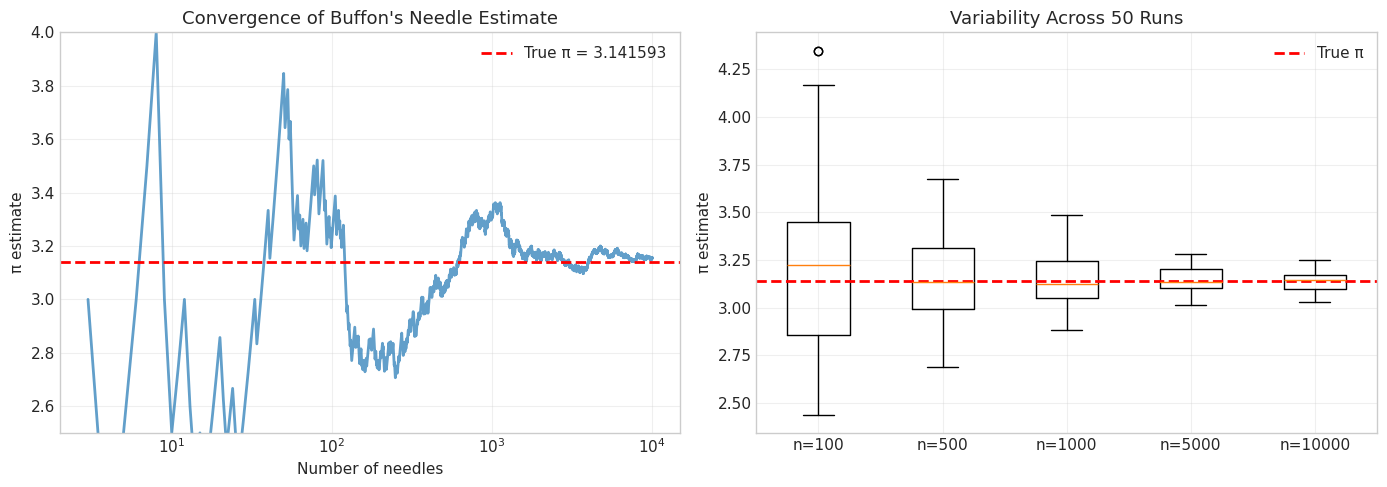

In [5]:
# Visualize convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Running estimate convergence
n_vals = np.arange(1, len(result['running_pi']) + 1)
axes[0].semilogx(n_vals, result['running_pi'], alpha=0.7)
axes[0].axhline(np.pi, color='red', linestyle='--', linewidth=2, label=f'True π = {np.pi:.6f}')
axes[0].set_xlabel('Number of needles')
axes[0].set_ylabel('π estimate')
axes[0].set_title('Convergence of Buffon\'s Needle Estimate')
axes[0].legend()
axes[0].set_ylim([2.5, 4.0])

# Panel 2: Multiple runs showing variability
n_runs = 50
sample_sizes = [100, 500, 1000, 5000, 10000]
estimates_by_n = {n: [] for n in sample_sizes}

for run in range(n_runs):
    for n in sample_sizes:
        res = buffon_needle_simulation(n, seed=run * 1000 + n)
        estimates_by_n[n].append(res['pi_estimate'])

positions = range(len(sample_sizes))
axes[1].boxplot([estimates_by_n[n] for n in sample_sizes], positions=positions)
axes[1].axhline(np.pi, color='red', linestyle='--', linewidth=2, label='True π')
axes[1].set_xticks(positions)
axes[1].set_xticklabels([f'n={n}' for n in sample_sizes])
axes[1].set_ylabel('π estimate')
axes[1].set_title(f'Variability Across {n_runs} Runs')
axes[1].legend()

plt.tight_layout()
plt.show()

## 2.1.2 The Core Monte Carlo Estimator

For any integral $I = \int_\mathcal{X} g(x)\,dx$, introduce density $f(x)$ on $\mathcal{X}$:

$$I = \int_\mathcal{X} \frac{g(x)}{f(x)} f(x)\,dx = \mathbb{E}_f\left[\frac{g(X)}{f(X)}\right]$$

For uniform $f(x) = 1/V$ on domain with volume $V$:

$$\hat{I}_n = \frac{V}{n}\sum_{i=1}^n g(X_i)$$

In [6]:
def monte_carlo_integrate(h_func: Callable, n_samples: int, 
                          sampler: Callable, volume: float = 1.0,
                          seed: int = 42) -> Dict:
    """
    General Monte Carlo integration.
    
    Parameters
    ----------
    h_func : callable
        Function to integrate (vectorized)
    n_samples : int
        Number of Monte Carlo samples
    sampler : callable
        Function sampler(rng, n) returning n samples from the domain
    volume : float
        Volume of integration domain (for uniform sampling)
    seed : int
        Random seed
        
    Returns
    -------
    dict
        estimate, std_error, confidence_interval, running_stats
    """
    rng = np.random.default_rng(seed)
    
    # Generate samples and evaluate
    X = sampler(rng, n_samples)
    h_values = h_func(X)
    
    # MC estimate and standard error
    estimate = volume * np.mean(h_values)
    std_error = volume * np.std(h_values, ddof=1) / np.sqrt(n_samples)
    
    # 95% CI
    ci_low = estimate - 1.96 * std_error
    ci_high = estimate + 1.96 * std_error
    
    # Running statistics for convergence analysis
    running_mean = volume * np.cumsum(h_values) / np.arange(1, n_samples + 1)
    running_var = np.zeros(n_samples)
    running_var[0] = 0
    for i in range(1, n_samples):
        running_var[i] = np.var(h_values[:i+1], ddof=1)
    running_se = volume * np.sqrt(running_var / np.arange(1, n_samples + 1))
    
    return {
        'estimate': estimate,
        'std_error': std_error,
        'ci': (ci_low, ci_high),
        'h_values': h_values,
        'running_mean': running_mean,
        'running_se': running_se,
        'sample_variance': np.var(h_values, ddof=1)
    }

# Example: Estimate ∫₀¹ e^(-x²) dx = √π/2 × erf(1) ≈ 0.7468
h = lambda x: np.exp(-x**2)
sampler = lambda rng, n: rng.uniform(0, 1, n)
true_value = np.sqrt(np.pi) / 2 * special.erf(1)

result = monte_carlo_integrate(h, 100000, sampler)

print("Monte Carlo Integration: ∫₀¹ e^(-x²) dx")
print("=" * 45)
print(f"MC Estimate:  {result['estimate']:.6f}")
print(f"True Value:   {true_value:.6f}")
print(f"Std Error:    {result['std_error']:.6f}")
print(f"95% CI:       ({result['ci'][0]:.6f}, {result['ci'][1]:.6f})")
print(f"CI contains true value: {result['ci'][0] <= true_value <= result['ci'][1]}")

Monte Carlo Integration: ∫₀¹ e^(-x²) dx
MC Estimate:  0.746396
True Value:   0.746824
Std Error:    0.000635
95% CI:       (0.745151, 0.747641)
CI contains true value: True


## 2.1.3 The $O(n^{-1/2})$ Convergence Rate

The CLT gives us:
- **Standard Error**: $\text{SE} = \sigma/\sqrt{n}$
- **To halve SE**: quadruple sample size
- **Dimension-independent**: Same rate in 1D or 100D!

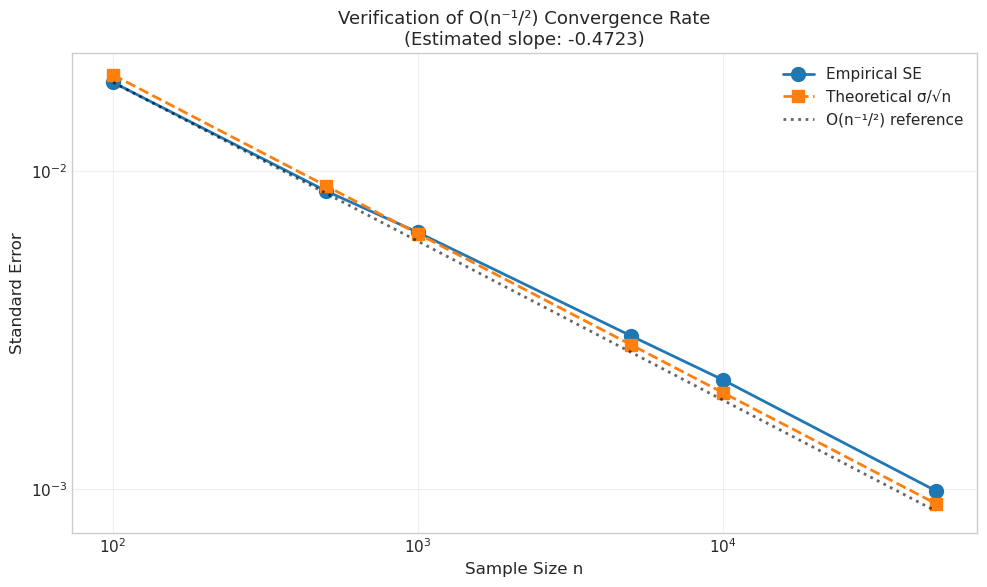

Slope of log(SE) vs log(n): -0.4723
Expected slope: -0.5
Deviation: 0.0277


In [7]:
def verify_convergence_rate(h_func: Callable, sampler: Callable, 
                            sample_sizes: List[int], true_value: float,
                            n_replications: int = 100, seed: int = 42) -> Dict:
    """
    Verify O(n^{-1/2}) convergence rate empirically.
    """
    results = {'n': [], 'mean_error': [], 'empirical_se': [], 'theoretical_se': []}
    
    # First estimate σ from a large sample
    rng_pilot = np.random.default_rng(seed)
    pilot_samples = h_func(sampler(rng_pilot, 100000))
    sigma = np.std(pilot_samples, ddof=1)
    
    for n in sample_sizes:
        estimates = []
        for rep in range(n_replications):
            rng = np.random.default_rng(seed + rep * 10000 + n)
            X = sampler(rng, n)
            estimates.append(np.mean(h_func(X)))
        
        estimates = np.array(estimates)
        results['n'].append(n)
        results['mean_error'].append(np.mean(np.abs(estimates - true_value)))
        results['empirical_se'].append(np.std(estimates, ddof=1))
        results['theoretical_se'].append(sigma / np.sqrt(n))
    
    return results

# Verify convergence rate
sample_sizes = [100, 500, 1000, 5000, 10000, 50000]
h = lambda x: np.exp(-x**2)
sampler = lambda rng, n: rng.uniform(0, 1, n)
true_value = np.sqrt(np.pi) / 2 * special.erf(1)

conv_results = verify_convergence_rate(h, sampler, sample_sizes, true_value)

# Compute slope
log_n = np.log(conv_results['n'])
log_se = np.log(conv_results['empirical_se'])
slope, _ = np.polyfit(log_n, log_se, 1)

# Single panel plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(conv_results['n'], conv_results['empirical_se'], 'o-', 
          label='Empirical SE', markersize=10, linewidth=2)
ax.loglog(conv_results['n'], conv_results['theoretical_se'], 's--', 
          label='Theoretical σ/√n', markersize=8, linewidth=2)

# Reference line with slope -0.5
n_ref = np.array(conv_results['n'])
ref_line = conv_results['empirical_se'][0] * (n_ref[0] / n_ref)**0.5
ax.loglog(n_ref, ref_line, 'k:', alpha=0.6, linewidth=2, label='O(n⁻¹/²) reference')

ax.set_xlabel('Sample Size n', fontsize=12)
ax.set_ylabel('Standard Error', fontsize=12)
ax.set_title(f'Verification of O(n⁻¹/²) Convergence Rate\n(Estimated slope: {slope:.4f})', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Slope of log(SE) vs log(n): {slope:.4f}")
print(f"Expected slope: -0.5")
print(f"Deviation: {abs(slope + 0.5):.4f}")

## 2.1.4 High-Dimensional Integration: The Monte Carlo Advantage

**Curse of Dimensionality for Grids**: Grid with $m$ points/dimension in $d$ dimensions needs $m^d$ points.

**Monte Carlo**: $O(n^{-1/2})$ regardless of $d$!

In [8]:
def product_integral_mc(d: int, n_samples: int, seed: int = 42) -> Dict:
    """
    Monte Carlo estimate of ∫_{[0,1]^d} ∏(1 + x_j/d) dx.
    
    True value: (1 + 1/(2d))^d → √e as d → ∞
    """
    rng = np.random.default_rng(seed)
    
    # Generate n × d uniform samples
    X = rng.random((n_samples, d))
    
    # Evaluate integrand: product over dimensions
    h_values = np.prod(1 + X / d, axis=1)
    
    estimate = np.mean(h_values)
    se = np.std(h_values, ddof=1) / np.sqrt(n_samples)
    true_value = (1 + 1 / (2 * d))**d
    
    return {
        'estimate': estimate,
        'std_error': se,
        'true_value': true_value,
        'error': abs(estimate - true_value),
        'd': d,
        'n': n_samples
    }

print("=" * 65)
print("MONTE CARLO IN HIGH DIMENSIONS")
print("=" * 65)
print(f"\nIntegrand: ∏(1 + xⱼ/d) over [0,1]^d")
print(f"True value: (1 + 1/(2d))^d → √e ≈ {np.sqrt(np.e):.6f} as d → ∞")

print(f"\n{'d':>5} {'True Value':>12} {'MC Estimate':>12} {'Std Error':>10} {'Error':>10}")
print("-" * 55)

dimensions = [1, 5, 10, 50, 100]
n_samples = 10000

for d in dimensions:
    result = product_integral_mc(d, n_samples, seed=42)
    print(f"{d:>5} {result['true_value']:>12.6f} {result['estimate']:>12.6f} "
          f"{result['std_error']:>10.6f} {result['error']:>10.6f}")

print(f"\n√e = {np.sqrt(np.e):.6f}")

MONTE CARLO IN HIGH DIMENSIONS

Integrand: ∏(1 + xⱼ/d) over [0,1]^d
True value: (1 + 1/(2d))^d → √e ≈ 1.648721 as d → ∞

    d   True Value  MC Estimate  Std Error      Error
-------------------------------------------------------
    1     1.500000     1.497122   0.002882   0.002878
    5     1.610510     1.611911   0.001907   0.001401
   10     1.628895     1.629903   0.001422   0.001009
   50     1.644632     1.643721   0.000666   0.000911
  100     1.646668     1.646704   0.000470   0.000036

√e = 1.648721


In [9]:
# Verify dimension-independent convergence rate
print(f"\n{'='*65}")
print("CONVERGENCE RATE VERIFICATION (d = 50)")
print(f"{'='*65}")

d = 50
sample_sizes_hd = [1000, 10000, 100000]
results_50d = []

print(f"\n{'n':>10} {'Estimate':>12} {'Std Error':>12} {'SE Ratio':>10}")
print("-" * 50)

for n in sample_sizes_hd:
    result = product_integral_mc(d, n, seed=42)
    results_50d.append(result)

for i, (n, result) in enumerate(zip(sample_sizes_hd, results_50d)):
    if i > 0:
        se_ratio = results_50d[i-1]['std_error'] / result['std_error']
        ratio_str = f"{se_ratio:>10.2f}"
    else:
        ratio_str = f"{'—':>10}"
    print(f"{n:>10} {result['estimate']:>12.6f} {result['std_error']:>12.6f} {ratio_str}")

print(f"\nExpected SE ratio when n × 10: √10 = {np.sqrt(10):.2f}")
print("The O(n^{-1/2}) rate holds even in 50 dimensions!")


CONVERGENCE RATE VERIFICATION (d = 50)

         n     Estimate    Std Error   SE Ratio
--------------------------------------------------
      1000     1.646039     0.002070          —
     10000     1.643721     0.000666       3.11
    100000     1.644537     0.000209       3.18

Expected SE ratio when n × 10: √10 = 3.16
The O(n^{-1/2}) rate holds even in 50 dimensions!


### Exercise 2.1: Monte Carlo vs Deterministic Methods

Compare Monte Carlo to the trapezoidal rule in 1D and extrapolate to high dimensions.

In [10]:
# EXERCISE 2.1 SOLUTION: Monte Carlo vs Trapezoidal

print("=" * 65)
print("MONTE CARLO VS TRAPEZOIDAL RULE (d = 1)")
print("=" * 65)

d = 1
true_value = (1 + 1/(2*d))**d

# Monte Carlo with n = 10000
result_mc = product_integral_mc(d, 10000, seed=42)
mc_error = abs(result_mc['estimate'] - true_value)

print(f"\nTrue value: {true_value}")
print(f"\nMonte Carlo (n = 10000):")
print(f"  Estimate: {result_mc['estimate']:.6f}")
print(f"  Error: {mc_error:.6f}")

# Trapezoidal rule at various grid sizes
def integrand_1d(x):
    return 1 + x

print(f"\nTrapezoidal Rule:")
print(f"{'n_grid':>10} {'Estimate':>12} {'Error':>12}")
print("-" * 40)

for n_grid in [10, 20, 50, 100, 200, 500]:
    x = np.linspace(0, 1, n_grid)
    trap_estimate = np.trapz(integrand_1d(x), x)
    trap_error = abs(trap_estimate - true_value)
    print(f"{n_grid:>10} {trap_estimate:>12.8f} {trap_error:>12.2e}")

print(f"\n>>> In 1D, trapezoidal rule WINS: O(n⁻²) vs O(n⁻¹/²)")
print(f">>> But in high dimensions...")

# The curse of dimensionality
print(f"\n{'='*65}")
print("THE CURSE OF DIMENSIONALITY")
print(f"{'='*65}")

print(f"\nTo achieve error ε ≈ 0.001:")
print(f"\n{'d':>5} {'Trap. pts/dim':>15} {'Total Trap. pts':>20} {'MC samples':>15}")
print("-" * 60)

m_per_dim = 32  # ≈ 1/√ε for error ≈ 0.001
mc_samples = 1_000_000

for d in [1, 2, 5, 10, 20]:
    trap_total = m_per_dim**d
    if trap_total < 1e15:
        trap_str = f"{trap_total:>20,.0f}"
    else:
        trap_str = f"{trap_total:>20.2e}"
    print(f"{d:>5} {m_per_dim:>15} {trap_str} {mc_samples:>15,}")

print(f"\n>>> At d = 20: Trapezoidal needs ≈ 10³⁰ points!")
print(f">>> Monte Carlo still needs only ~10⁶ points.")
print(f">>> MONTE CARLO WINS in high dimensions!")

MONTE CARLO VS TRAPEZOIDAL RULE (d = 1)

True value: 1.5

Monte Carlo (n = 10000):
  Estimate: 1.497122
  Error: 0.002878

Trapezoidal Rule:
    n_grid     Estimate        Error
----------------------------------------
        10   1.50000000     0.00e+00
        20   1.50000000     4.44e-16
        50   1.50000000     0.00e+00
       100   1.50000000     0.00e+00
       200   1.50000000     0.00e+00
       500   1.50000000     0.00e+00

>>> In 1D, trapezoidal rule WINS: O(n⁻²) vs O(n⁻¹/²)
>>> But in high dimensions...

THE CURSE OF DIMENSIONALITY

To achieve error ε ≈ 0.001:

    d   Trap. pts/dim      Total Trap. pts      MC samples
------------------------------------------------------------
    1              32                   32       1,000,000
    2              32                1,024       1,000,000
    5              32           33,554,432       1,000,000
   10              32             1.13e+15       1,000,000
   20              32             1.27e+30       1,000,000



---

# Section 2.2: Uniform Random Variates (PRNGs)

Every random number in computing starts as a **uniform** variate. The **Probability Integral Transform** tells us:

> If $U \sim \text{Uniform}(0,1)$ and $F$ is any CDF, then $X = F^{-1}(U) \sim F$.

**Get the uniforms right, and everything else follows.**

## 2.2.1 Linear Congruential Generators (LCGs)

The most common historical PRNG:

$$X_{n+1} = (aX_n + c) \mod m$$

Uniform variates: $U_n = X_n / m$

**Hull-Dobell Theorem**: For mixed LCG ($c \neq 0$), period = $m$ iff:
1. $\gcd(c, m) = 1$
2. $a - 1$ divisible by all prime factors of $m$
3. If $4 | m$, then $4 | (a-1)$

In [11]:
class LinearCongruentialGenerator:
    """
    Linear Congruential Generator implementation.
    
    X_{n+1} = (a * X_n + c) mod m
    """
    
    def __init__(self, a: int, c: int, m: int, seed: int):
        self.a = a
        self.c = c
        self.m = m
        self.state = seed % m
        
    def next_int(self) -> int:
        """Generate next integer in sequence."""
        self.state = (self.a * self.state + self.c) % self.m
        return self.state
    
    def random(self) -> float:
        """Generate uniform on [0, 1)."""
        return self.next_int() / self.m
    
    def generate(self, n: int) -> np.ndarray:
        """Generate n uniform variates."""
        return np.array([self.random() for _ in range(n)])

# Good LCG (Numerical Recipes parameters)
good_lcg = LinearCongruentialGenerator(
    a=1664525, c=1013904223, m=2**32, seed=42
)

# Generate samples and test
samples = good_lcg.generate(10000)

print("LCG Quality Test (Numerical Recipes parameters)")
print("=" * 50)
print(f"Parameters: a={good_lcg.a}, c={good_lcg.c}, m=2³²")
print(f"Mean: {np.mean(samples):.6f} (expected: 0.5)")
print(f"Std:  {np.std(samples):.6f} (expected: {1/np.sqrt(12):.6f})")
print(f"Min:  {np.min(samples):.6f}")
print(f"Max:  {np.max(samples):.6f}")

LCG Quality Test (Numerical Recipes parameters)
Parameters: a=1664525, c=1013904223, m=2³²
Mean: 0.504030 (expected: 0.5)
Std:  0.290687 (expected: 0.288675)
Min:  0.000339
Max:  0.999856


## 2.2.2 The RANDU Disaster

IBM's RANDU (1960s) used $a = 65539 = 2^{16} + 3$, $c = 0$, $m = 2^{31}$.

**The Problem**: All consecutive triples $(U_n, U_{n+1}, U_{n+2})$ lie on just **15 parallel planes** in $[0,1]^3$!

This caused years of corrupted simulation results.

In [12]:
class LinearCongruentialGenerator:
    def __init__(self, a: int, c: int, m: int, seed: int):
        self.a = a
        self.c = c
        self.m = m
        self.state = seed % m
        
    def next_int(self) -> int:
        self.state = (self.a * self.state + self.c) % self.m
        return self.state
    
    def random(self) -> float:
        return self.next_int() / self.m
    
    def generate(self, n: int) -> np.ndarray:
        return np.array([self.random() for _ in range(n)])

# RANDU generator
randu = LinearCongruentialGenerator(a=65539, c=0, m=2**31, seed=1)

n_points = 5000
randu_samples = randu.generate(3 * n_points)
x = randu_samples[0::3]
y = randu_samples[1::3]
z = randu_samples[2::3]

# Good generator
rng_good = np.random.default_rng(42)
good_samples = rng_good.random(3 * n_points)
x_good = good_samples[0::3]
y_good = good_samples[1::3]
z_good = good_samples[2::3]

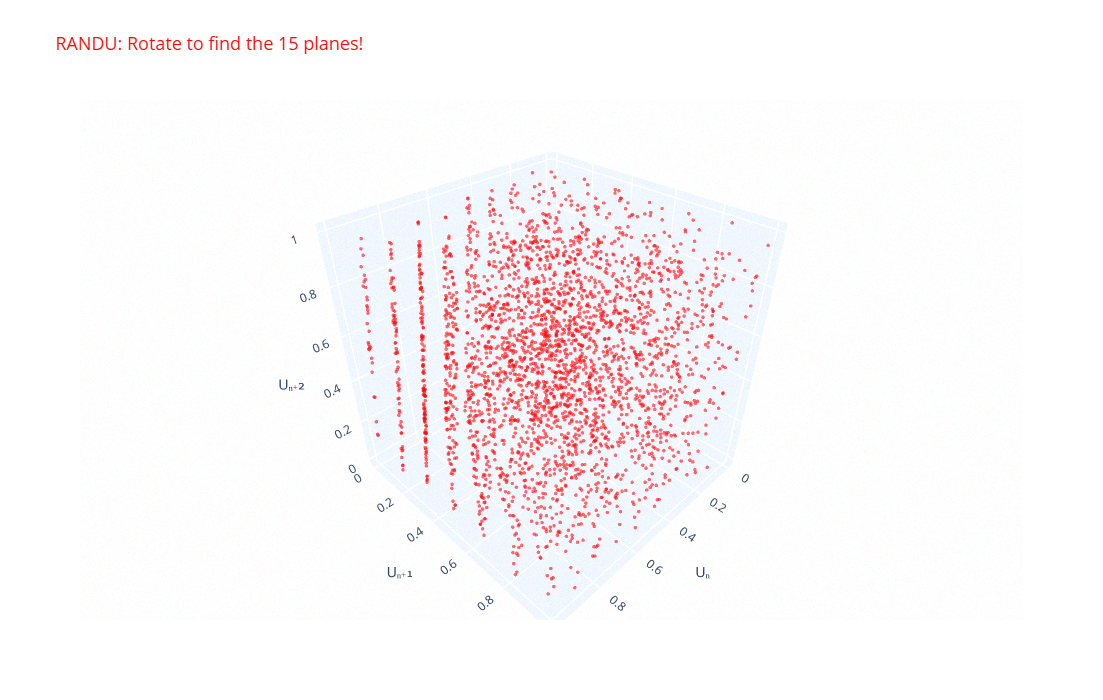

In [13]:
# RANDU - Plotly (smooth rotation)
fig1 = go.Figure(data=[go.Scatter3d(
    x=x[:3000], y=y[:3000], z=z[:3000],
    mode='markers',
    marker=dict(size=2, color='red', opacity=0.6)
)])

fig1.update_layout(
    title=dict(text='RANDU: Rotate to find the 15 planes!', font=dict(size=18, color='red')),
    scene=dict(
        xaxis_title='Uₙ',
        yaxis_title='Uₙ₊₁',
        zaxis_title='Uₙ₊₂'
    ),
    width=800, height=700
)
fig1.show()

In [14]:
# PCG64 - Plotly
fig2 = go.Figure(data=[go.Scatter3d(
    x=x_good[:3000], y=y_good[:3000], z=z_good[:3000],
    mode='markers',
    marker=dict(size=2, color='green', opacity=0.6)
)])

fig2.update_layout(
    title=dict(text='PCG64: Proper 3D coverage', font=dict(size=18, color='green')),
    scene=dict(
        xaxis_title='Uₙ',
        yaxis_title='Uₙ₊₁',
        zaxis_title='Uₙ₊₂'
    ),
    width=800, height=700
)
fig2.show()

## 2.2.3 Modern Best Practice: NumPy's Generator API

**Always use**: `np.random.default_rng(seed)`

**For parallel computing**: `SeedSequence.spawn()`

In [15]:
# Modern NumPy random API best practices

print("=" * 60)
print("MODERN NUMPY RANDOM API BEST PRACTICES")
print("=" * 60)

# 1. Reproducibility with explicit seeds
print("\n1. REPRODUCIBILITY")
rng1 = default_rng(42)
rng2 = default_rng(42)
print(f"   Same seed → same sequence: {np.allclose(rng1.random(5), rng2.random(5))}")

# 2. Parallel streams with SeedSequence
print("\n2. PARALLEL STREAMS")
master_seed = 12345
ss = SeedSequence(master_seed)
child_seeds = ss.spawn(4)
parallel_rngs = [default_rng(s) for s in child_seeds]

print(f"   Master seed: {master_seed}")
print(f"   Created {len(parallel_rngs)} independent generators")

# Verify independence
all_samples = [rng.random(10000) for rng in parallel_rngs]
print(f"\n   Pairwise correlations (should be ~0):")
for i in range(4):
    for j in range(i+1, 4):
        corr = np.corrcoef(all_samples[i], all_samples[j])[0, 1]
        print(f"     Workers {i} & {j}: {corr:.6f}")

# 3. Generator info
print("\n3. DEFAULT GENERATOR INFO")
rng = default_rng(42)
print(f"   BitGenerator: {type(rng.bit_generator).__name__}")
print(f"   State size: 128 bits")
print(f"   Period: 2^128")

MODERN NUMPY RANDOM API BEST PRACTICES

1. REPRODUCIBILITY
   Same seed → same sequence: True

2. PARALLEL STREAMS
   Master seed: 12345
   Created 4 independent generators

   Pairwise correlations (should be ~0):
     Workers 0 & 1: -0.010335
     Workers 0 & 2: -0.032860
     Workers 0 & 3: -0.013113
     Workers 1 & 2: -0.009638
     Workers 1 & 3: -0.001684
     Workers 2 & 3: -0.002984

3. DEFAULT GENERATOR INFO
   BitGenerator: PCG64
   State size: 128 bits
   Period: 2^128


---

# Section 2.3: Inverse CDF Method

**Theorem (Probability Integral Transform)**: If $U \sim \text{Uniform}(0,1)$ and $F$ is any CDF, then

$$X = F^{-1}(U) \sim F$$

where $F^{-1}(u) = \inf\{x : F(x) \geq u\}$ is the generalized inverse (quantile function).

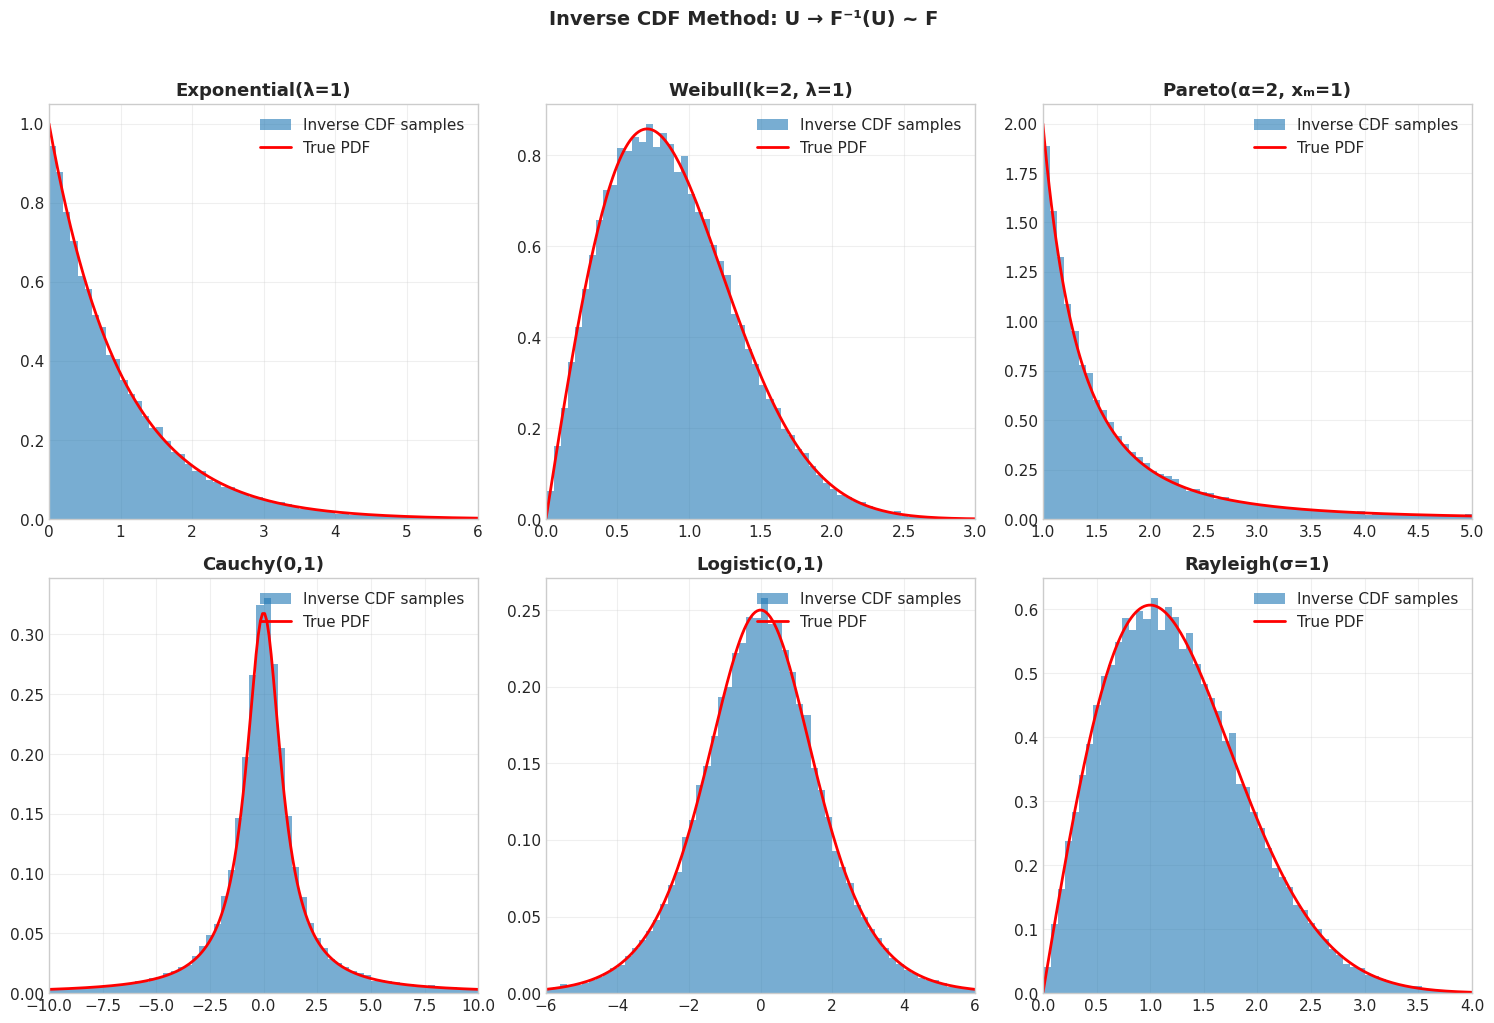

In [16]:
def demonstrate_inverse_cdf():
    """
    Demonstrate the inverse CDF method for several distributions.
    """
    rng = np.random.default_rng(42)
    n = 50000
    U = rng.random(n)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    distributions = [
        ('Exponential(λ=1)', lambda u: -np.log(1-u), stats.expon, (0, 6)),
        ('Weibull(k=2, λ=1)', lambda u: (-np.log(1-u))**0.5, stats.weibull_min(2), (0, 3)),
        ('Pareto(α=2, xₘ=1)', lambda u: (1-u)**(-1/2), lambda: stats.pareto(2, scale=1), (1, 5)),
        ('Cauchy(0,1)', lambda u: np.tan(np.pi*(u - 0.5)), stats.cauchy, (-10, 10)),
        ('Logistic(0,1)', lambda u: np.log(u/(1-u)), stats.logistic, (-6, 6)),
        ('Rayleigh(σ=1)', lambda u: np.sqrt(-2*np.log(1-u)), stats.rayleigh, (0, 4)),
    ]
    
    for ax, (name, inv_cdf, dist, xlim) in zip(axes.flat, distributions):
        # Generate samples via inverse CDF
        X = inv_cdf(U)
        
        # Filter to plot range
        mask = (X > xlim[0]) & (X < xlim[1])
        ax.hist(X[mask], bins=60, density=True, alpha=0.6, label='Inverse CDF samples')
        
        # True PDF
        x_grid = np.linspace(xlim[0], xlim[1], 200)
        if callable(dist):
            ax.plot(x_grid, dist().pdf(x_grid), 'r-', lw=2, label='True PDF')
        else:
            ax.plot(x_grid, dist.pdf(x_grid), 'r-', lw=2, label='True PDF')
        
        ax.set_title(name, fontweight='bold')
        ax.set_xlim(xlim)
        ax.legend(loc='upper right')
    
    plt.suptitle('Inverse CDF Method: U → F⁻¹(U) ~ F', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

demonstrate_inverse_cdf()

## 2.3.1 Closed-Form Inverse CDFs

| Distribution | CDF $F(x)$ | Inverse $F^{-1}(u)$ |
|-------------|------------|--------------------|
| Exponential($\lambda$) | $1 - e^{-\lambda x}$ | $-\ln(1-u)/\lambda$ |
| Weibull($k, \lambda$) | $1 - e^{-(x/\lambda)^k}$ | $\lambda(-\ln(1-u))^{1/k}$ |
| Pareto($\alpha, x_m$) | $1 - (x_m/x)^\alpha$ | $x_m(1-u)^{-1/\alpha}$ |
| Cauchy($\mu, \sigma$) | $\frac{1}{2} + \frac{1}{\pi}\arctan\frac{x-\mu}{\sigma}$ | $\mu + \sigma\tan(\pi(u-1/2))$ |

## Verification via Kolmogorov–Smirnov Test

The **Kolmogorov–Smirnov (KS) test** is a nonparametric goodness-of-fit test that compares an empirical distribution to a theoretical reference distribution.

### Test Statistic

The KS statistic measures the maximum vertical distance between the empirical CDF $\hat{F}_n(x)$ and the theoretical CDF $F(x)$:

$$D_n = \sup_x \left| \hat{F}_n(x) - F(x) \right|$$

where $\hat{F}_n(x) = \frac{1}{n} \sum_{i=1}^{n} \mathbf{1}_{X_i \leq x}$ is the empirical CDF.

### Hypotheses

$$H_0: \text{The samples come from the specified distribution } F$$
$$H_1: \text{The samples do not come from } F$$

### Assumptions

1. **Independence**: Samples $X_1, X_2, \ldots, X_n$ are independent
2. **Continuous distribution**: The theoretical CDF $F$ is continuous
3. **Fully specified**: The reference distribution is completely known (no estimated parameters)

### Decision Rule

- **p-value > 0.05**: Fail to reject $H_0$ — no evidence against the implementation
- **p-value ≤ 0.05**: Reject $H_0$ — implementation may be incorrect

### Why KS Test for Inverse CDF Verification?

1. **Distribution-free**: Works for any continuous distribution without assumptions about shape
2. **Sensitive to location, scale, and shape**: Detects various types of errors in the transformation
3. **Exact p-values**: For fully specified null distributions, p-values are exact (not asymptotic)

### Interpretation Caveat

A high p-value does **not** prove correctness — it only indicates no detected deviation. With $n = 100{,}000$ samples, the test has high power to detect even small implementation errors.

In [17]:
def exponential_invcdf(u: np.ndarray, rate: float = 1.0) -> np.ndarray:
    """Generate Exponential(rate) samples via inverse CDF."""
    return -np.log1p(-u) / rate

def weibull_invcdf(u: np.ndarray, k: float, scale: float = 1.0) -> np.ndarray:
    """Generate Weibull(k, scale) samples via inverse CDF."""
    return scale * (-np.log1p(-u))**(1/k)

def pareto_invcdf(u: np.ndarray, alpha: float, x_m: float = 1.0) -> np.ndarray:
    """Generate Pareto(alpha, x_m) samples via inverse CDF."""
    return x_m * (1 - u)**(-1/alpha)

def cauchy_invcdf(u: np.ndarray, loc: float = 0.0, scale: float = 1.0) -> np.ndarray:
    """Generate Cauchy(loc, scale) samples via inverse CDF."""
    return loc + scale * np.tan(np.pi * (u - 0.5))

# Verify implementations
rng = np.random.default_rng(42)
n = 100000

print("Inverse CDF Implementation Verification")
print("=" * 60)
print(f"\n{'Distribution':<20} {'Sample Mean':>12} {'True Mean':>12} {'KS p-value':>12}")
print("-" * 60)

# Exponential
U = rng.random(n)
samples = exponential_invcdf(U, 2)
dist = stats.expon(scale=0.5)
 # Kolmogorov–Smirnov test
_, p_value = stats.kstest(samples, dist.cdf)
print(f"{'Exponential(2)':<20} {np.mean(samples):>12.4f} {dist.mean():>12.4f} {p_value:>12.4f}")

# Weibull
U = rng.random(n)
samples = weibull_invcdf(U, 1.5, 2)
dist = stats.weibull_min(1.5, scale=2)
 # Kolmogorov–Smirnov test
_, p_value = stats.kstest(samples, dist.cdf)
print(f"{'Weibull(1.5, 2)':<20} {np.mean(samples):>12.4f} {dist.mean():>12.4f} {p_value:>12.4f}")

# Cauchy
U = rng.random(n)
samples = cauchy_invcdf(U)
dist = stats.cauchy()
 # Kolmogorov–Smirnov test
_, p_value = stats.kstest(samples, dist.cdf)
print(f"{'Cauchy(0, 1)':<20} {np.median(samples):>12.4f}* {'undefined':>12} {p_value:>12.4f}")

print("\n* Median shown for Cauchy (mean undefined)")
print(">>> p-values > 0.05 confirms correct implementation")

Inverse CDF Implementation Verification

Distribution          Sample Mean    True Mean   KS p-value
------------------------------------------------------------
Exponential(2)             0.5007       0.5000       0.3313
Weibull(1.5, 2)            1.8042       1.8055       0.5407
Cauchy(0, 1)               0.0028*    undefined       0.5785

* Median shown for Cauchy (mean undefined)
>>> p-values > 0.05 confirms correct implementation


## 2.3.2 Discrete Distribution Sampling

For discrete distribution with PMF $p_1, p_2, \ldots, p_K$:

$$F^{-1}(u) = \min\{k : F(k) \geq u\} = \min\left\{k : \sum_{j=1}^k p_j \geq u\right\}$$

**Methods**:
- Linear search: $O(K)$ per sample
- Binary search: $O(\log K)$ per sample  
- Alias method: $O(1)$ per sample after $O(K)$ setup

In [18]:
def discrete_invcdf_linear(u: float, probs: np.ndarray, values: np.ndarray) -> float:
    """Linear search: O(K) per sample."""
    cumsum = 0.0
    for i, p in enumerate(probs):
        cumsum += p
        if u <= cumsum:
            return values[i]
    return values[-1]

def discrete_invcdf_binary(u: float, cdf: np.ndarray, values: np.ndarray) -> float:
    """Binary search: O(log K) per sample."""
    idx = np.searchsorted(cdf, u, side='left')
    idx = min(idx, len(values) - 1)  # Numerical safety
    return values[idx]

def discrete_sample_vectorized(n: int, probs: np.ndarray, values: np.ndarray, 
                                rng: np.random.Generator) -> np.ndarray:
    """Vectorized binary search for efficiency."""
    cdf = np.cumsum(probs)
    U = rng.random(n)
    indices = np.searchsorted(cdf, U, side='left')
    indices = np.clip(indices, 0, len(values) - 1)
    return values[indices]

# Example: Loaded die
probs = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.5])  # 6 is loaded
values = np.arange(1, 7)

rng = np.random.default_rng(42)
samples = discrete_sample_vectorized(100000, probs, values, rng)

print("Discrete Sampling: Loaded Die")
print("=" * 45)
print(f"\n{'Face':>6} {'True Prob':>12} {'Empirical':>12}")
print("-" * 35)

for v, p in zip(values, probs):
    emp = np.mean(samples == v)
    print(f"{v:>6} {p:>12.3f} {emp:>12.3f}")

Discrete Sampling: Loaded Die

  Face    True Prob    Empirical
-----------------------------------
     1        0.100        0.099
     2        0.100        0.100
     3        0.100        0.100
     4        0.100        0.098
     5        0.100        0.100
     6        0.500        0.503


## 2.3.3 Discrete Sampling: Algorithm Complexity Analysis

When sampling from discrete distributions with $K$ categories, the choice of algorithm significantly impacts performance. Here we analyze four key algorithms.

### Linear Scan Inversion

**Complexity**: $O(K)$ per draw, $O(1)$ setup

The simplest approach—scan through the CDF until $U \leq F(x_k)$:

| Metric | Value |
|--------|-------|
| Time (draw) | $O(K)$ worst/average |
| Space | $O(K)$ for CDF |
| Updates | $O(K)$ to rebuild CDF |

*Best for*: Small $K$, frequently changing weights.

In [19]:
def linear_scan_inversion(categories, probs, n=1, rng=None):
    """Inverse CDF sampling via linear scan. O(K) per draw."""
    rng = np.random.default_rng(rng)
    categories = np.asarray(categories)
    probs = np.asarray(probs)
    samples = np.empty(n, dtype=categories.dtype)
    
    for i in range(n):
        u = rng.random()
        cumsum = 0.0
        for j, p in enumerate(probs):
            cumsum += p
            if u <= cumsum:
                samples[i] = categories[j]
                break
    return samples

# Test
probs = np.array([0.1, 0.2, 0.3, 0.25, 0.15])
samples = linear_scan_inversion(np.arange(5), probs, 10000, rng=42)
print("Linear Scan Results:")
print(f"{'Cat':<5} {'True':>8} {'Empirical':>10}")
for i, p in enumerate(probs):
    print(f"{i:<5} {p:>8.3f} {np.mean(samples==i):>10.4f}")

Linear Scan Results:
Cat       True  Empirical
0        0.100     0.0984
1        0.200     0.2059
2        0.300     0.3005
3        0.250     0.2477
4        0.150     0.1475


### Binary Search Inversion

**Complexity**: $O(\log K)$ per draw, $O(K)$ setup for CDF

Uses binary search on the cumulative distribution:

| Metric | Value |
|--------|-------|
| Time (draw) | $O(\log K)$ |
| Space | $O(K)$ for CDF |
| Updates | $O(K)$ to rebuild CDF |

*Best for*: Medium to large $K$ with static weights.

In [20]:
def binary_search_inversion(categories, probs, n=1, rng=None):
    """Inverse CDF sampling via binary search. O(log K) per draw."""
    rng = np.random.default_rng(rng)
    categories = np.asarray(categories)
    cdf = np.cumsum(probs)
    
    U = rng.random(n)
    indices = np.searchsorted(cdf, U, side='left')
    indices = np.clip(indices, 0, len(categories) - 1)
    return categories[indices]

# Comparison test
samples_binary = binary_search_inversion(np.arange(5), probs, 10000, rng=42)
print("Binary Search Results:")
print(f"{'Cat':<5} {'True':>8} {'Empirical':>10}")
for i, p in enumerate(probs):
    print(f"{i:<5} {p:>8.3f} {np.mean(samples_binary==i):>10.4f}")

Binary Search Results:
Cat       True  Empirical
0        0.100     0.0984
1        0.200     0.2059
2        0.300     0.3005
3        0.250     0.2477
4        0.150     0.1475


### Walker's Alias Method

**Complexity**: $O(1)$ per draw (!), $O(K)$ setup

The alias method achieves constant-time sampling by preprocessing the distribution into a table where each column has height exactly 1, containing at most 2 categories.

| Phase | Time | Space |
|-------|------|-------|
| Build | $\Theta(K)$ | $2K$ arrays |
| Draw | $\Theta(1)$ | — |
| Update | $\Theta(K)$ | rebuild required |

**Per-draw cost**: Exactly 2 random numbers + 1 comparison.

*Best for*: Large $K$ with many samples from static weights.

In [21]:
class AliasTable:
    """
    Walker's Alias Method for O(1) discrete sampling.
    
    The trick: reshape any PMF into K columns of height 1, each containing
    at most 2 categories. Then sampling = pick random column + coin flip.
    """
    def __init__(self, probs):
        probs = np.asarray(probs, dtype=float)
        K = len(probs)
        self.prob = np.zeros(K)
        self.alias = np.zeros(K, dtype=int)
        
        # Scale so probabilities sum to K
        scaled = probs * K
        
        # Partition into small (< 1) and large (>= 1)
        small, large = [], []
        for i, p in enumerate(scaled):
            (small if p < 1.0 else large).append(i)
        
        # Build table: pair each small with a large
        while small and large:
            l, g = small.pop(), large.pop()
            self.prob[l] = scaled[l]
            self.alias[l] = g
            scaled[g] = scaled[g] + scaled[l] - 1.0
            (small if scaled[g] < 1.0 else large).append(g)
        
        # Remaining entries are exactly 1
        for i in large + small:
            self.prob[i] = 1.0
    
    def sample(self, n, rng=None):
        """Generate n samples in O(n) time."""
        rng = np.random.default_rng(rng)
        K = len(self.prob)
        cols = rng.integers(0, K, size=n)
        coins = rng.random(n)
        return np.where(coins < self.prob[cols], cols, self.alias[cols])

# Demonstrate
probs_demo = np.array([0.1, 0.2, 0.3, 0.4])
alias = AliasTable(probs_demo)

print("Alias Method Demonstration")
print("=" * 45)
print(f"\nTable structure (p = {list(probs_demo)}):")
print(f"{'Col':<5} {'Prob':<10} {'Alias':<8}")
for i in range(len(probs_demo)):
    print(f"{i:<5} {alias.prob[i]:<10.4f} {alias.alias[i]:<8}")

samples_alias = alias.sample(100000, rng=42)
print(f"\nVerification (100k samples):")
print(f"{'Cat':<5} {'True':>8} {'Empirical':>10}")
for i, p in enumerate(probs_demo):
    print(f"{i:<5} {p:>8.3f} {np.mean(samples_alias==i):>10.4f}")

Alias Method Demonstration

Table structure (p = [0.1, 0.2, 0.3, 0.4]):
Col   Prob       Alias   
0     0.4000     3       
1     0.8000     3       
2     1.0000     0       
3     0.8000     2       

Verification (100k samples):
Cat       True  Empirical
0        0.100     0.0998
1        0.200     0.1998
2        0.300     0.3016
3        0.400     0.3987


In [22]:
# Timing comparison of discrete sampling algorithms
import time

def time_sampling(method_name, sample_func, K, n_samples=50000):
    """Time a sampling method."""
    probs = np.ones(K) / K  # Uniform for fair comparison
    categories = np.arange(K)
    
    start = time.perf_counter()
    if method_name == 'Alias':
        table = AliasTable(probs)
        table.sample(n_samples, rng=42)
    else:
        sample_func(categories, probs, n_samples, rng=42)
    return time.perf_counter() - start

print("Timing Comparison: Discrete Sampling Methods")
print("=" * 60)
print(f"{'K':<10} {'Linear (ms)':<15} {'Binary (ms)':<15} {'Alias (ms)':<15}")
print("-" * 55)

for K in [10, 100, 1000, 10000]:
    t_linear = 1000 * time_sampling('Linear', linear_scan_inversion, K)
    t_binary = 1000 * time_sampling('Binary', binary_search_inversion, K)
    t_alias = 1000 * time_sampling('Alias', None, K)
    print(f"{K:<10} {t_linear:<15.2f} {t_binary:<15.2f} {t_alias:<15.2f}")

print("\n>>> For large K with many draws, Alias method dominates!")
print(">>> Binary search is the practical default for most cases.")

Timing Comparison: Discrete Sampling Methods
K          Linear (ms)     Binary (ms)     Alias (ms)     
-------------------------------------------------------
10         71.69           1.71            0.82           
100        318.25          2.56            0.70           
1000       3287.19         3.65            2.58           
10000      31154.68        5.34            2.61           

>>> For large K with many draws, Alias method dominates!
>>> Binary search is the practical default for most cases.


---

# Section 2.4: Transformation Methods

When the inverse CDF is intractable (like the normal distribution), we use **transformation methods** that exploit mathematical relationships between distributions.

## 2.4.1 The Box-Muller Transform

**Problem**: Normal CDF $\Phi(z) = \int_{-\infty}^z \frac{1}{\sqrt{2\pi}}e^{-t^2/2}dt$ has no closed form.

**Solution**: Consider two independent standard normals $(Z_1, Z_2)$. In polar coordinates:

$$R^2 = Z_1^2 + Z_2^2 \sim \chi^2_2 = \text{Exponential}(1/2)$$
$$\Theta = \arctan(Z_2/Z_1) \sim \text{Uniform}(0, 2\pi)$$

**Inversion**: Given $U_1, U_2 \sim \text{Uniform}(0,1)$:

$$Z_1 = \sqrt{-2\ln U_1} \cos(2\pi U_2), \quad Z_2 = \sqrt{-2\ln U_1} \sin(2\pi U_2)$$

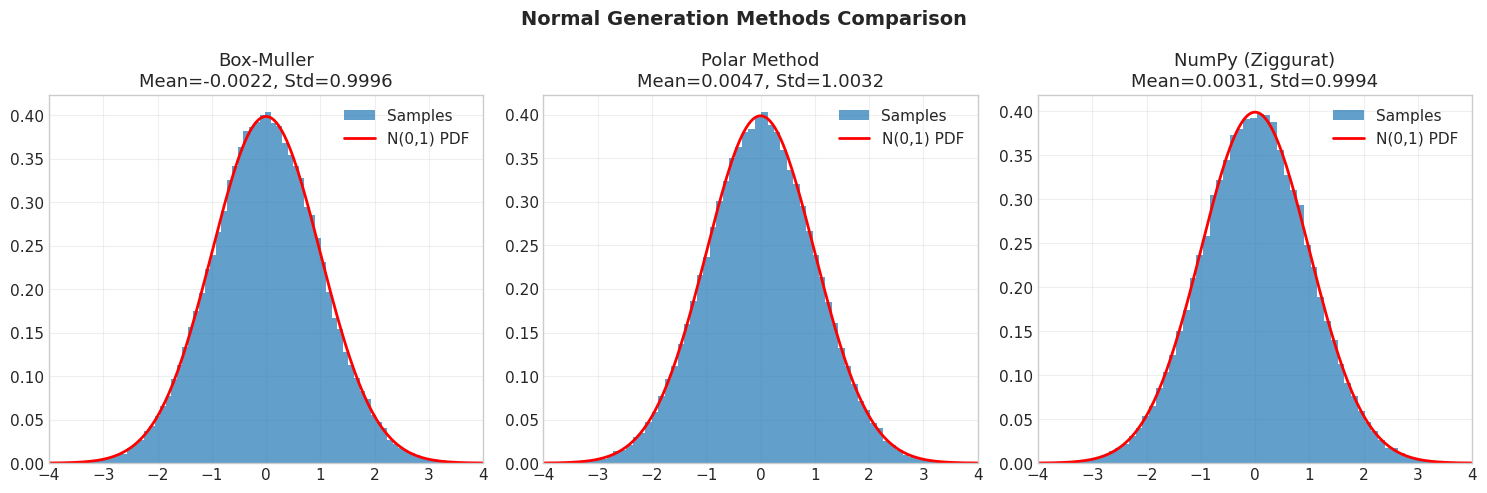

In [23]:
def box_muller(n: int, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
    """
    Box-Muller transform: 2 uniforms → 2 independent standard normals.
    
    Returns
    -------
    Z1, Z2 : arrays
        Two arrays of n independent standard normal samples
    """
    U1 = rng.random(n)
    U2 = rng.random(n)
    
    R = np.sqrt(-2 * np.log(U1))  # Radius (use log, not log1p, since U1 > 0)
    theta = 2 * np.pi * U2        # Angle
    
    Z1 = R * np.cos(theta)
    Z2 = R * np.sin(theta)
    
    return Z1, Z2

def polar_method(n: int, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
    """
    Marsaglia polar method: avoids trig functions.
    
    Accept-reject to get uniform point in unit disk, then transform.
    Average acceptance rate: π/4 ≈ 78.5%
    """
    Z1 = np.zeros(n)
    Z2 = np.zeros(n)
    generated = 0
    
    while generated < n:
        # Generate in [-1, 1]²
        V1 = 2 * rng.random() - 1
        V2 = 2 * rng.random() - 1
        S = V1**2 + V2**2
        
        # Accept if inside unit disk
        if 0 < S < 1:
            mult = np.sqrt(-2 * np.log(S) / S)
            Z1[generated] = V1 * mult
            Z2[generated] = V2 * mult
            generated += 1
    
    return Z1, Z2

# Compare methods
rng = np.random.default_rng(42)
n = 50000

Z1_bm, Z2_bm = box_muller(n, rng)
rng = np.random.default_rng(42)  # Reset for fair comparison
Z1_polar, Z2_polar = polar_method(n, rng)
Z_numpy = rng.standard_normal(2 * n)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (Z, title) in zip(axes, [
    (np.concatenate([Z1_bm, Z2_bm]), 'Box-Muller'),
    (np.concatenate([Z1_polar, Z2_polar]), 'Polar Method'),
    (Z_numpy, 'NumPy (Ziggurat)')
]):
    ax.hist(Z, bins=80, density=True, alpha=0.7, label='Samples')
    x = np.linspace(-4, 4, 200)
    ax.plot(x, stats.norm.pdf(x), 'r-', lw=2, label='N(0,1) PDF')
    ax.set_title(f'{title}\nMean={np.mean(Z):.4f}, Std={np.std(Z):.4f}')
    ax.legend()
    ax.set_xlim(-4, 4)

plt.suptitle('Normal Generation Methods Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2.4.2 The Distribution Hierarchy

From standard normals, we can generate many other distributions:

| Distribution | Formula | Application |
|-------------|---------|-------------|
| $\chi^2_\nu$ | $\sum_{i=1}^\nu Z_i^2$ | Variance estimation |
| $t_\nu$ | $Z / \sqrt{V/\nu}$, $V \sim \chi^2_\nu$ | Small-sample inference |
| $F_{\nu_1,\nu_2}$ | $(V_1/\nu_1)/(V_2/\nu_2)$ | ANOVA |
| LogNormal$(\mu,\sigma)$ | $e^{\mu + \sigma Z}$ | Positive data modeling |

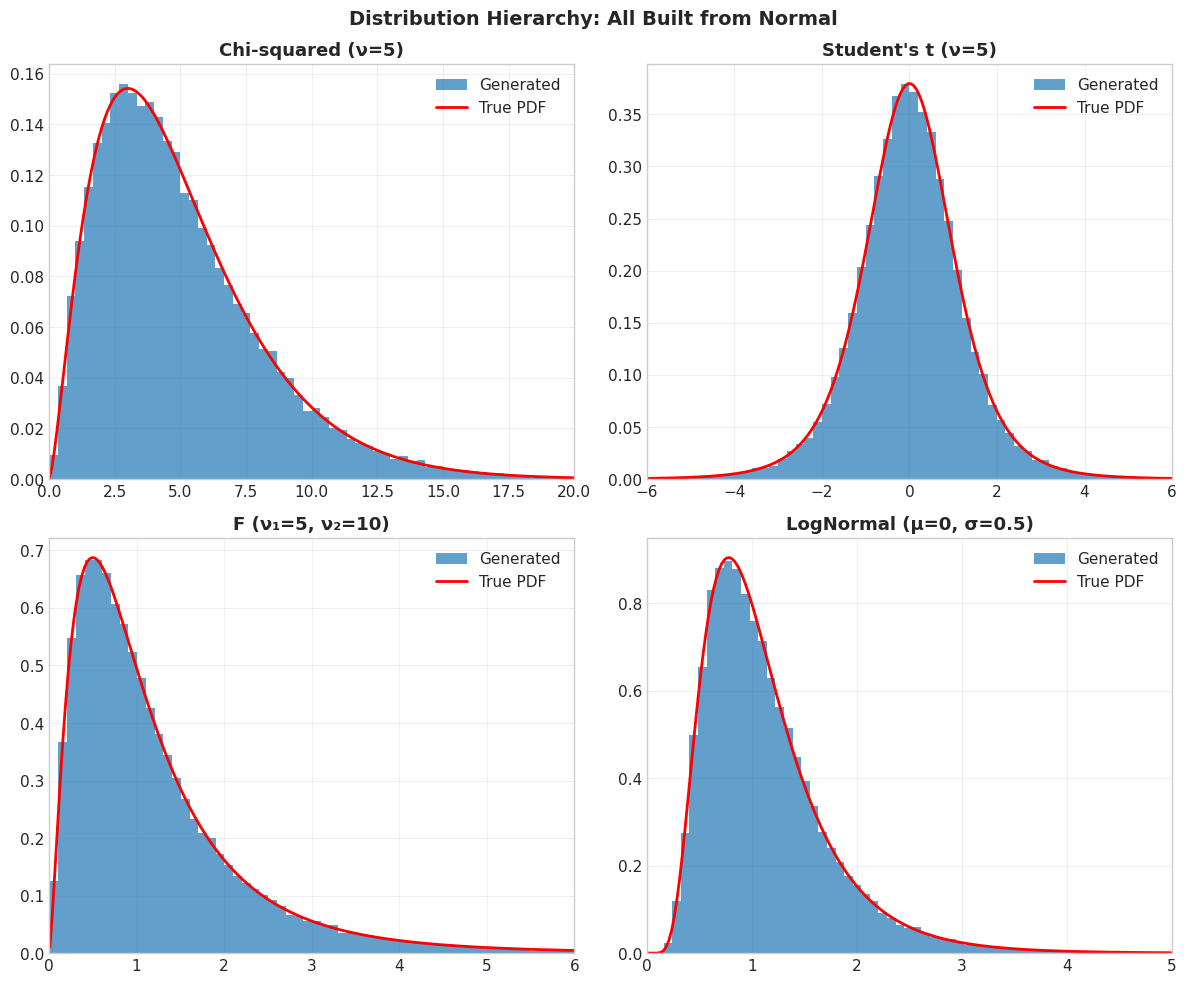

In [24]:
def chi_squared(nu: int, n: int, rng: np.random.Generator) -> np.ndarray:
    """Generate χ²(ν) samples as sum of ν squared standard normals."""
    Z = rng.standard_normal((n, nu))
    return np.sum(Z**2, axis=1)

def student_t(nu: int, n: int, rng: np.random.Generator) -> np.ndarray:
    """Generate t(ν) samples as Z / √(V/ν) where V ~ χ²(ν)."""
    Z = rng.standard_normal(n)
    V = chi_squared(nu, n, rng)
    return Z / np.sqrt(V / nu)

def f_distribution(nu1: int, nu2: int, n: int, rng: np.random.Generator) -> np.ndarray:
    """Generate F(ν₁, ν₂) samples."""
    V1 = chi_squared(nu1, n, rng)
    V2 = chi_squared(nu2, n, rng)
    return (V1 / nu1) / (V2 / nu2)

def lognormal(mu: float, sigma: float, n: int, rng: np.random.Generator) -> np.ndarray:
    """Generate LogNormal(μ, σ) samples."""
    Z = rng.standard_normal(n)
    return np.exp(mu + sigma * Z)

# Visualize the hierarchy
rng = np.random.default_rng(42)
n = 50000

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

distributions = [
    ('Chi-squared (ν=5)', chi_squared(5, n, rng), stats.chi2(5), (0, 20)),
    ('Student\'s t (ν=5)', student_t(5, n, rng), stats.t(5), (-6, 6)),
    ('F (ν₁=5, ν₂=10)', f_distribution(5, 10, n, rng), stats.f(5, 10), (0, 6)),
    ('LogNormal (μ=0, σ=0.5)', lognormal(0, 0.5, n, rng), stats.lognorm(0.5), (0, 5)),
]

for ax, (name, samples, dist, xlim) in zip(axes.flat, distributions):
    mask = (samples > xlim[0]) & (samples < xlim[1])
    ax.hist(samples[mask], bins=60, density=True, alpha=0.7, label='Generated')
    x = np.linspace(xlim[0] + 0.01, xlim[1], 200)
    ax.plot(x, dist.pdf(x), 'r-', lw=2, label='True PDF')
    ax.set_title(name, fontweight='bold')
    ax.set_xlim(xlim)
    ax.legend()

plt.suptitle('Distribution Hierarchy: All Built from Normal', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2.4.3 Multivariate Normal Generation

For $\mathbf{X} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$:

$$\mathbf{X} = \boldsymbol{\mu} + \mathbf{L}\mathbf{Z}$$

where $\mathbf{Z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ and $\mathbf{L}$ is the Cholesky factor: $\boldsymbol{\Sigma} = \mathbf{L}\mathbf{L}^T$

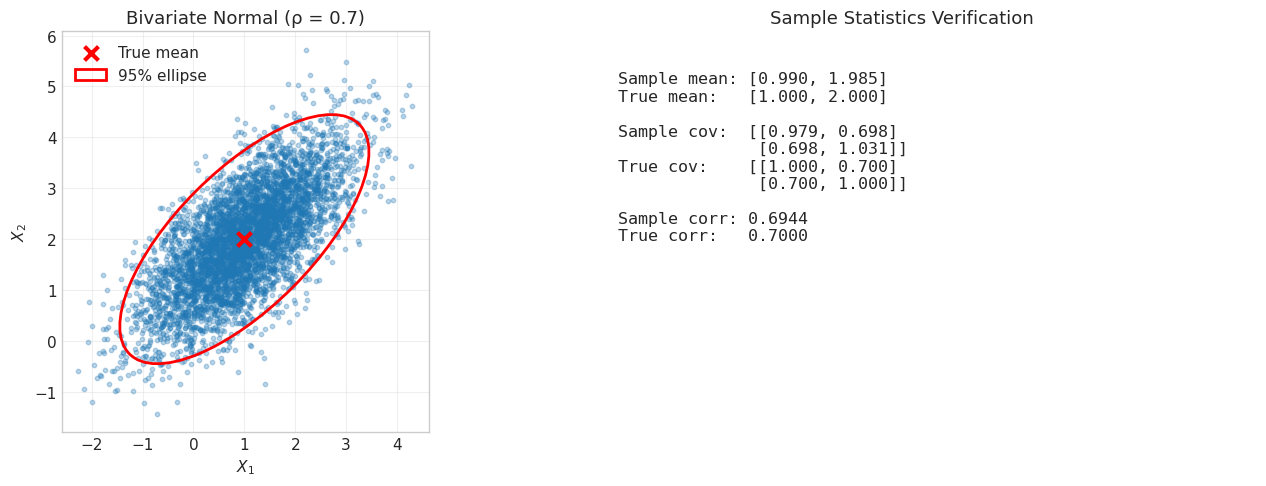

In [36]:
def multivariate_normal(mean: np.ndarray, cov: np.ndarray, n: int,
                        rng: np.random.Generator) -> np.ndarray:
    """
    Generate multivariate normal samples via Cholesky factorization.
    """
    d = len(mean)
    L = np.linalg.cholesky(cov)
    Z = rng.standard_normal((n, d))
    X = mean + Z @ L.T
    return X

# Example: Bivariate normal with correlation
mean = np.array([1.0, 2.0])
rho = 0.7
cov = np.array([[1.0, rho], [rho, 1.0]])

rng = np.random.default_rng(42)
samples = multivariate_normal(mean, cov, 5000, rng)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=10)
ax.scatter(*mean, color='red', s=100, marker='x', linewidths=3, label='True mean')

# Draw 95% ellipse - FIX: eigenvalues are sorted ascending
from matplotlib.patches import Ellipse
eigenvalues, eigenvectors = np.linalg.eigh(cov)

# The angle of the MAJOR axis (largest eigenvalue, index 1)
angle = np.degrees(np.arctan2(eigenvectors[1, 1], eigenvectors[0, 1]))

# FIX: width corresponds to major axis (larger eigenvalue), height to minor
# Ellipse width is along x-axis before rotation, so assign major axis to width
width = 2 * np.sqrt(5.991 * eigenvalues[1])   # Major axis (larger eigenvalue)
height = 2 * np.sqrt(5.991 * eigenvalues[0])  # Minor axis (smaller eigenvalue)

ellipse = Ellipse(mean, width, height, angle=angle, fill=False, 
                  color='red', linewidth=2, label='95% ellipse')
ax.add_patch(ellipse)
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
ax.set_title(f'Bivariate Normal (ρ = {rho})')
ax.legend()
ax.set_aspect('equal')

# Verify statistics
ax = axes[1]
info = [
    f"Sample mean: [{np.mean(samples[:,0]):.3f}, {np.mean(samples[:,1]):.3f}]",
    f"True mean:   [{mean[0]:.3f}, {mean[1]:.3f}]",
    "",
    f"Sample cov:  [[{np.cov(samples.T)[0,0]:.3f}, {np.cov(samples.T)[0,1]:.3f}]",
    f"              [{np.cov(samples.T)[1,0]:.3f}, {np.cov(samples.T)[1,1]:.3f}]]",
    f"True cov:    [[{cov[0,0]:.3f}, {cov[0,1]:.3f}]",
    f"              [{cov[1,0]:.3f}, {cov[1,1]:.3f}]]",
    "",
    f"Sample corr: {np.corrcoef(samples.T)[0,1]:.4f}",
    f"True corr:   {rho:.4f}"
]
ax.text(0.1, 0.9, '\n'.join(info), transform=ax.transAxes, fontsize=12,
        verticalalignment='top', fontfamily='monospace')
ax.axis('off')
ax.set_title('Sample Statistics Verification')

plt.tight_layout()
plt.show()

---

# Section 2.5: Rejection Sampling

**When to use**: When the inverse CDF is intractable and no simple transformation exists.

**The Accept-Reject Algorithm**:
1. Find proposal $g(x)$ easy to sample and constant $M$ such that $f(x) \leq M \cdot g(x)$ for all $x$
2. Sample $X \sim g$ and $U \sim \text{Uniform}(0, 1)$
3. Accept $X$ if $U \leq f(X) / (M \cdot g(X))$; otherwise reject and repeat

**Acceptance rate**: $1/M$ (want $M$ as small as possible)

In [26]:
def rejection_sampler(target_pdf: Callable, proposal_sampler: Callable,
                      proposal_pdf: Callable, M: float, n: int,
                      rng: np.random.Generator) -> Tuple[np.ndarray, float]:
    """
    General rejection sampling algorithm.
    
    Parameters
    ----------
    target_pdf : callable
        Target density f(x) (can be unnormalized)
    proposal_sampler : callable
        Function to sample from proposal g
    proposal_pdf : callable
        Proposal density g(x)
    M : float
        Envelope constant such that f(x) ≤ M·g(x) for all x
    n : int
        Number of samples to generate
    rng : Generator
        NumPy random generator
        
    Returns
    -------
    samples : ndarray
        n samples from target distribution
    acceptance_rate : float
        Fraction of proposals accepted
    """
    samples = []
    n_proposed = 0
    
    while len(samples) < n:
        # Propose from g
        X = proposal_sampler(rng)
        U = rng.random()
        n_proposed += 1
        
        # Accept with probability f(X) / (M · g(X))
        acceptance_prob = target_pdf(X) / (M * proposal_pdf(X))
        
        if U <= acceptance_prob:
            samples.append(X)
    
    acceptance_rate = n / n_proposed
    return np.array(samples), acceptance_rate

## 2.5.1 Example: Beta Distribution Sampling

The Beta$(\alpha, \beta)$ distribution has PDF:

$$f(x) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}, \quad x \in (0, 1)$$

For $\alpha, \beta > 1$, the mode is at $x^* = (\alpha-1)/(\alpha+\beta-2)$.

Beta(2, 5) Rejection Sampling
Acceptance rate: 40.51%
Theoretical (1/M): 40.69%

Sample mean: 0.2859
True mean:   0.2857


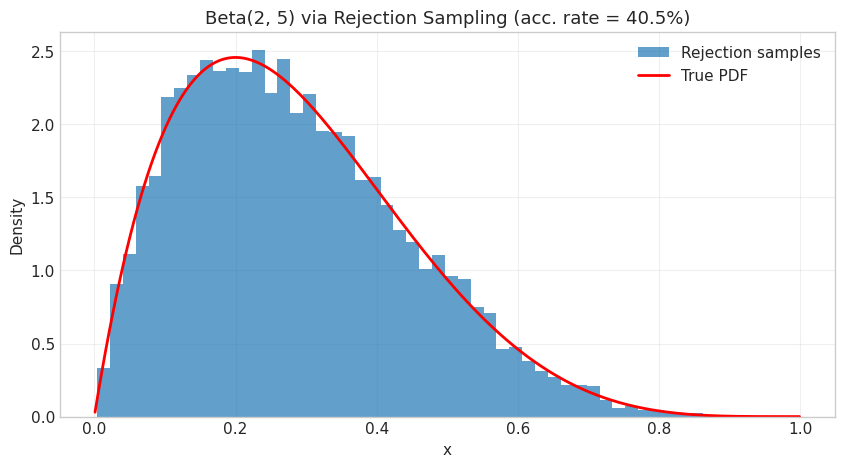

In [27]:
def beta_rejection_sampler(alpha: float, beta: float, n: int, 
                           rng: np.random.Generator) -> Tuple[np.ndarray, float]:
    """
    Sample from Beta(α, β) using rejection with Uniform(0,1) proposal.
    
    Works for α, β ≥ 1 where the PDF is bounded.
    """
    # For α, β ≥ 1, max PDF is at mode
    if alpha >= 1 and beta >= 1:
        if alpha == 1 and beta == 1:
            mode = 0.5
        elif alpha == 1:
            mode = 0.0
        elif beta == 1:
            mode = 1.0
        else:
            mode = (alpha - 1) / (alpha + beta - 2)
        
        M = stats.beta.pdf(mode, alpha, beta)
    else:
        raise ValueError("This simple sampler requires α, β ≥ 1")
    
    target_pdf = lambda x: stats.beta.pdf(x, alpha, beta)
    proposal_sampler = lambda rng: rng.random()
    proposal_pdf = lambda x: 1.0  # Uniform(0,1)
    
    return rejection_sampler(target_pdf, proposal_sampler, proposal_pdf, M, n, rng)

# Example: Beta(2, 5)
alpha, beta_param = 2, 5
rng = np.random.default_rng(42)

samples, acc_rate = beta_rejection_sampler(alpha, beta_param, 10000, rng)

print(f"Beta({alpha}, {beta_param}) Rejection Sampling")
print("=" * 45)
print(f"Acceptance rate: {acc_rate:.2%}")
print(f"Theoretical (1/M): {1/stats.beta.pdf((alpha-1)/(alpha+beta_param-2), alpha, beta_param):.2%}")
print(f"\nSample mean: {np.mean(samples):.4f}")
print(f"True mean:   {alpha/(alpha+beta_param):.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(samples, bins=50, density=True, alpha=0.7, label='Rejection samples')
x = np.linspace(0.001, 0.999, 200)
ax.plot(x, stats.beta.pdf(x, alpha, beta_param), 'r-', lw=2, label='True PDF')
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title(f'Beta({alpha}, {beta_param}) via Rejection Sampling (acc. rate = {acc_rate:.1%})')
ax.legend()
plt.show()

### Exercise 2.5: Bayesian Posterior Sampling

Use rejection sampling to sample from a posterior distribution.

In [28]:
# EXERCISE 2.5 SOLUTION: Bayesian Posterior via Rejection Sampling

# Setup: Poisson data with Gamma prior
# Prior: λ ~ Gamma(2, 0.5)  [shape, rate]
# Data: n=25 observations, sum=58
# Posterior: Gamma(2+58, 0.5+25) = Gamma(60, 25.5)  [conjugate result]

alpha_prior, beta_prior = 2, 0.5
n_obs, sum_x = 25, 58

# True posterior (conjugate)
alpha_post = alpha_prior + sum_x  # = 60
beta_post = beta_prior + n_obs    # = 25.5
posterior = stats.gamma(a=alpha_post, scale=1/beta_post)

print("Bayesian Poisson-Gamma Inference")
print("=" * 55)
print(f"Prior: Gamma(α={alpha_prior}, β={beta_prior})")
print(f"Data: n={n_obs}, Σxᵢ={sum_x}")
print(f"Posterior: Gamma(α={alpha_post}, β={beta_post})")

# Proposal: Gamma(50, 20) - intentionally different
alpha_prop, beta_prop = 50, 20
proposal = stats.gamma(a=alpha_prop, scale=1/beta_prop)

# Find envelope constant M
# Ratio f(λ)/g(λ) is maximized at some λ*
lambda_star = (alpha_post - alpha_prop) / (beta_post - beta_prop)  # = 10/5.5
log_f_star = posterior.logpdf(lambda_star)
log_g_star = proposal.logpdf(lambda_star)
M = np.exp(log_f_star - log_g_star) * 1.01  # Safety margin

print(f"\nProposal: Gamma(α={alpha_prop}, β={beta_prop})")
print(f"Envelope constant M = {M:.4f}")
print(f"Theoretical acceptance rate: {1/M:.2%}")

# Rejection sampler using log-space for stability
def rejection_posterior(n_samples, seed=42):
    rng = np.random.default_rng(seed)
    samples = []
    n_proposed = 0
    
    while len(samples) < n_samples:
        lam = rng.gamma(alpha_prop, scale=1/beta_prop)
        u = rng.random()
        n_proposed += 1
        
        # Log-space acceptance
        log_accept = posterior.logpdf(lam) - np.log(M) - proposal.logpdf(lam)
        if np.log(u) <= log_accept:
            samples.append(lam)
    
    return np.array(samples), n_samples / n_proposed

# Generate samples both ways
rejection_samples, acc_rate = rejection_posterior(10000)
direct_samples = posterior.rvs(size=10000, random_state=42)

print(f"\n{'='*55}")
print("SAMPLING COMPARISON")
print(f"{'='*55}")
print(f"\n{'Method':<20} {'Mean':>10} {'Std':>10} {'95% CI':<25}")
print("-" * 65)

# Rejection samples
rej_ci = np.percentile(rejection_samples, [2.5, 97.5])
print(f"{'Rejection':<20} {np.mean(rejection_samples):>10.4f} {np.std(rejection_samples):>10.4f} ({rej_ci[0]:.4f}, {rej_ci[1]:.4f})")

# Direct samples  
dir_ci = np.percentile(direct_samples, [2.5, 97.5])
print(f"{'Direct (Gamma)':<20} {np.mean(direct_samples):>10.4f} {np.std(direct_samples):>10.4f} ({dir_ci[0]:.4f}, {dir_ci[1]:.4f})")

# Analytical
ana_ci = posterior.ppf([0.025, 0.975])
print(f"{'Analytical':<20} {posterior.mean():>10.4f} {posterior.std():>10.4f} ({ana_ci[0]:.4f}, {ana_ci[1]:.4f})")

print(f"\nActual acceptance rate: {acc_rate:.2%}")

# P(λ > 2.5 | data)
prob_analytical = 1 - posterior.cdf(2.5)
prob_rejection = np.mean(rejection_samples > 2.5)

print(f"\nP(λ > 2.5 | data):")
print(f"  Analytical: {prob_analytical:.4f}")
print(f"  Rejection MC: {prob_rejection:.4f}")

Bayesian Poisson-Gamma Inference
Prior: Gamma(α=2, β=0.5)
Data: n=25, Σxᵢ=58
Posterior: Gamma(α=60, β=25.5)

Proposal: Gamma(α=50, β=20)
Envelope constant M = 1.7408
Theoretical acceptance rate: 57.45%

SAMPLING COMPARISON

Method                     Mean        Std 95% CI                   
-----------------------------------------------------------------
Rejection                2.3519     0.3006 (1.7943, 2.9667)
Direct (Gamma)           2.3585     0.3016 (1.7984, 2.9807)
Analytical               2.3529     0.3038 (1.7955, 2.9845)

Actual acceptance rate: 57.65%

P(λ > 2.5 | data):
  Analytical: 0.3025
  Rejection MC: 0.2939


### Visualizing Rejection Sampling Efficiency

The acceptance rate depends critically on how tightly the envelope $M \cdot g(x)$ wraps the target $f(x)$. For Beta distributions, this varies dramatically with parameters.

**The Uniform Proposal Limitation**

When using $g(x) = \text{Uniform}(0,1)$ as the proposal, we need:
$$M = \max_x f(x) \quad \text{such that} \quad f(x) \leq M \quad \forall x \in [0,1]$$

This works perfectly when the target PDF is **bounded** (i.e., $\alpha \geq 1$ and $\beta \geq 1$):

| Parameters | Shape | $M = \max f(x)$ | Acceptance Rate |
|------------|-------|-----------------|-----------------|
| Beta(2, 5) | Right-skewed | 2.0 | ~44% |
| Beta(5, 2) | Left-skewed | 2.0 | ~40% |
| Beta(5, 5) | Symmetric | 2.5 | ~37% |
| Beta(2, 2) | Symmetric | 1.5 | ~61% |

**The U-Shaped Problem**

For **U-shaped** Beta distributions ($\alpha < 1$ or $\beta < 1$), the PDF is **unbounded**:
$$f(x) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha,\beta)} \to \infty \quad \text{as } x \to 0 \text{ or } x \to 1$$

For example, Beta(0.5, 0.5) has $f(x) \propto x^{-0.5}(1-x)^{-0.5}$, which blows up at both boundaries. **No finite $M$ exists** for a uniform envelope, so we need smarter proposals.

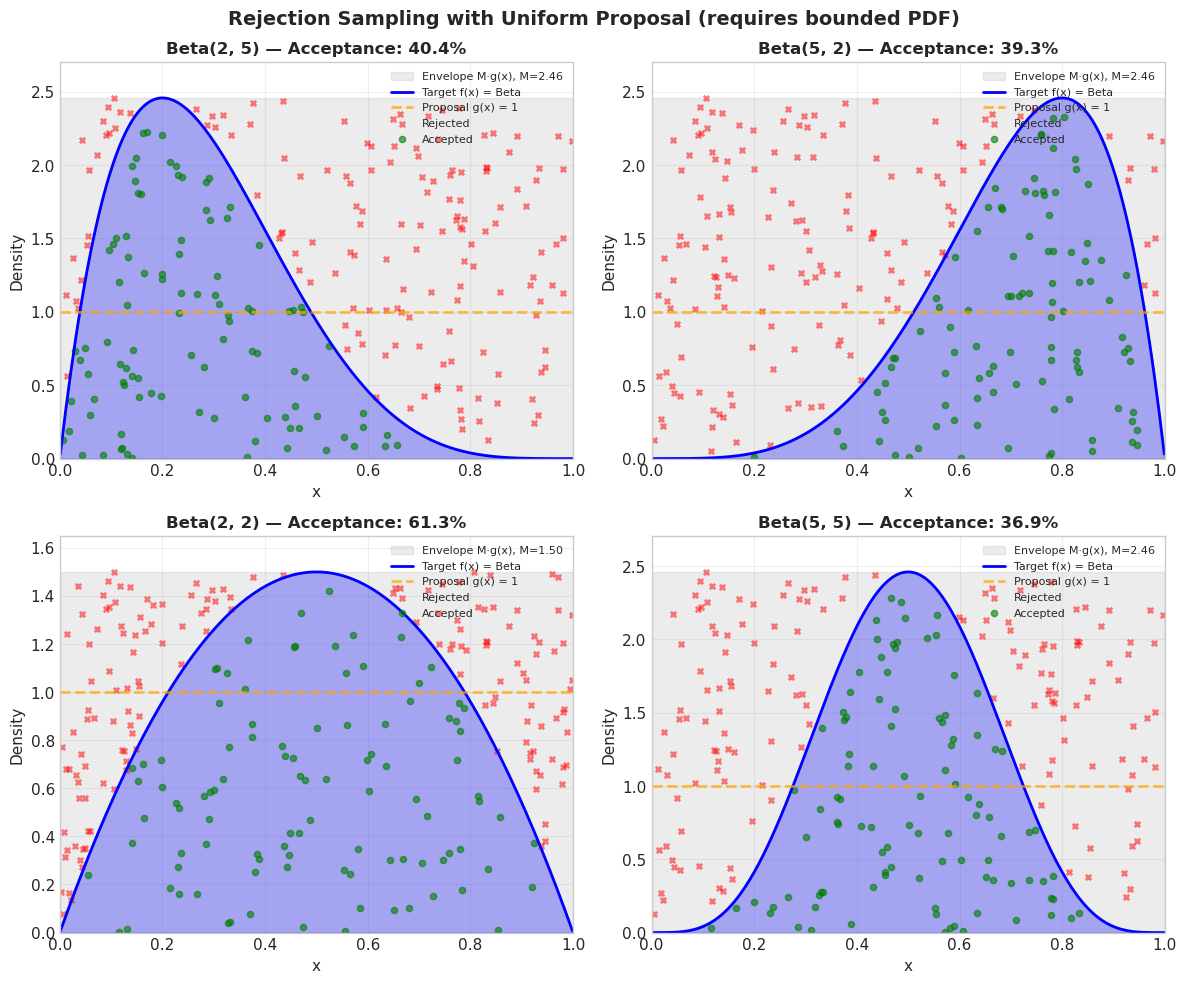

Note: Uniform proposal only works when target PDF is bounded (α ≥ 1 and β ≥ 1)
Theoretical acceptance rate = 1/M = Area under PDF / Area of envelope


In [37]:
# =============================================================================
# PART 1: Fixed 2x2 grid - replace U-shape with a valid case
# =============================================================================

def sample_beta_with_visualization(alpha, beta_param, n=500, rng=None):
    """Sample Beta with tracking of accepted/rejected points using Uniform proposal."""
    rng = np.random.default_rng(rng)
    
    # For uniform proposal, need bounded PDF (α ≥ 1 and β ≥ 1)
    if alpha < 1 or beta_param < 1:
        raise ValueError("Uniform proposal requires α ≥ 1 and β ≥ 1")
    
    # Find mode and envelope constant
    if alpha > 1 and beta_param > 1:
        mode = (alpha - 1) / (alpha + beta_param - 2)
    elif alpha == 1:
        mode = 0.01
    else:  # beta_param == 1
        mode = 0.99
    
    M = stats.beta.pdf(mode, alpha, beta_param)
    
    samples, rej_x, rej_y = [], [], []
    while len(samples) < n:
        x = rng.random()
        y = rng.random() * M
        if y <= stats.beta.pdf(x, alpha, beta_param):
            samples.append(x)
        else:
            rej_x.append(x)
            rej_y.append(y)
    
    acc_rate = len(samples) / (len(samples) + len(rej_x))
    return np.array(samples), np.array(rej_x), np.array(rej_y), acc_rate, M

# 2x2 grid with valid cases only (all have bounded PDFs)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
param_sets = [(2, 5), (5, 2), (2, 2), (5, 5)]  # Replaced (0.5, 0.5) with (2, 2)

for ax, (a, b) in zip(axes.flat, param_sets):
    samples, rej_x, rej_y, acc_rate, M = sample_beta_with_visualization(a, b, n=300, rng=42)
    
    x_grid = np.linspace(0.001, 0.999, 200)
    pdf_vals = stats.beta.pdf(x_grid, a, b)
    
    ax.fill_between(x_grid, 0, M, alpha=0.15, color='gray', label=f'Envelope M·g(x), M={M:.2f}')
    ax.fill_between(x_grid, 0, pdf_vals, alpha=0.3, color='blue')
    ax.plot(x_grid, pdf_vals, 'b-', linewidth=2, label='Target f(x) = Beta')
    ax.axhline(1, color='orange', linestyle='--', alpha=0.7, label='Proposal g(x) = 1')
    
    # Show rejected points
    n_show = min(150, len(rej_x))
    ax.scatter(rej_x[:n_show], rej_y[:n_show], c='red', s=15, alpha=0.5, label='Rejected', marker='x')
    
    # Show accepted points at random heights under the PDF
    rng_vis = np.random.default_rng(123)
    n_acc_show = min(100, len(samples))
    y_accepted = stats.beta.pdf(samples[:n_acc_show], a, b) * rng_vis.random(n_acc_show)
    ax.scatter(samples[:n_acc_show], y_accepted, c='green', s=20, alpha=0.6, label='Accepted')
    
    ax.set_title(f'Beta({a}, {b}) — Acceptance: {acc_rate:.1%}', fontweight='bold', fontsize=12)
    ax.legend(fontsize=8, loc='upper right')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, M * 1.1)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')

plt.suptitle('Rejection Sampling with Uniform Proposal (requires bounded PDF)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Note: Uniform proposal only works when target PDF is bounded (α ≥ 1 and β ≥ 1)")
print(f"Theoretical acceptance rate = 1/M = Area under PDF / Area of envelope")

### Specialized Algorithms for U-Shaped Beta Distributions

When $\alpha < 1$ or $\beta < 1$, the standard uniform proposal fails. Here are two elegant solutions:

---

#### Algorithm 1: Jöhnk's Method (1964)

A geometric approach that transforms the problem into a simple acceptance region.

**Key Insight**: If $U, V \sim \text{Uniform}(0,1)$ are independent, define:
$$X = U^{1/\alpha}, \quad Y = V^{1/\beta}$$

Then $\frac{X}{X+Y} \sim \text{Beta}(\alpha, \beta)$ **conditional on** $X + Y \leq 1$.

**Algorithm**:
1. Generate $U, V \sim \text{Uniform}(0,1)$
2. Compute $X = U^{1/\alpha}$, $Y = V^{1/\beta}$
3. If $X + Y \leq 1$: return $X/(X+Y)$
4. Else: reject and go to step 1

**Acceptance Rate**: $\alpha \cdot \beta \cdot B(\alpha, \beta)$ — for Beta(0.5, 0.5) this is $0.25\pi \approx 79\%$.

**Pros**: Elegant, no numerical optimization needed  
**Cons**: Only works when both $\alpha \leq 1$ and $\beta \leq 1$
---

#### Algorithm 2: Mixture Proposal

Match the proposal's tail behavior to the target's singularities.

**Key Insight**: Near the boundaries, Beta($\alpha, \beta$) behaves like:
- $x^{\alpha-1}$ as $x \to 0$ — matches Beta($\alpha$, 1)
- $(1-x)^{\beta-1}$ as $x \to 1$ — matches Beta(1, $\beta$)

**Proposal**: Use a 50-50 mixture:
$$g(x) = \frac{1}{2} \cdot \underbrace{\alpha x^{\alpha-1}}_{\text{Beta}(\alpha, 1)} + \frac{1}{2} \cdot \underbrace{\beta(1-x)^{\beta-1}}_{\text{Beta}(1, \beta)}$$

Both components have **closed-form inverse CDFs**:
- Beta($\alpha$, 1): $F^{-1}(u) = u^{1/\alpha}$
- Beta(1, $\beta$): $F^{-1}(u) = 1 - (1-u)^{1/\beta}$

**Algorithm**:
1. Flip fair coin to choose component
2. If heads: $X = U^{1/\alpha}$ (sample from Beta($\alpha$, 1))
3. If tails: $X = 1 - (1-U)^{1/\beta}$ (sample from Beta(1, $\beta$))
4. Accept with probability $\frac{f(X)}{M \cdot g(X)}$

**Acceptance Rate**: For Beta(0.5, 0.5):
$$M = \max_x \frac{f(x)}{g(x)} = \frac{4}{\pi} \approx 1.27 \quad \Rightarrow \quad \text{Rate} = \frac{1}{M} = \frac{\pi}{4} \approx 79\%$$

The maximum occurs at $x = 0.5$ where both proposal components contribute equally.

**Pros**: Works for any $\alpha, \beta > 0$; generalizable pattern  
**Cons**: Requires finding $M = \max \frac{f(x)}{g(x)}$ (analytically or numerically)

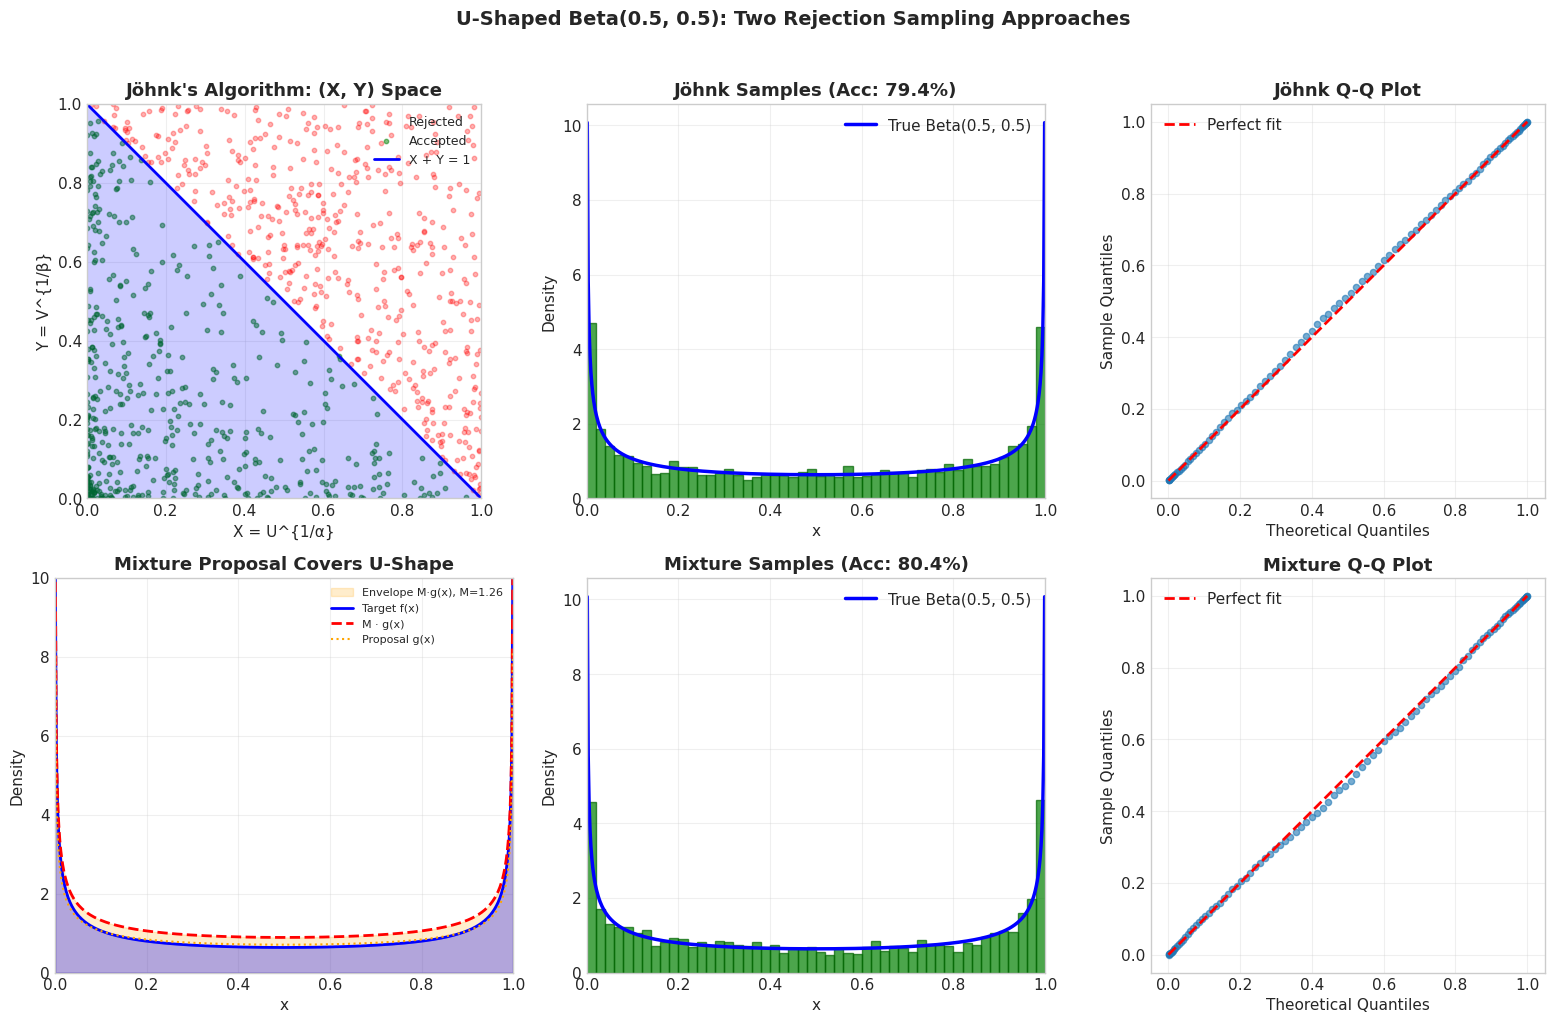

COMPARISON: Sampling Beta(0.5, 0.5) — U-Shaped Distribution

Metric                              Jöhnk         Mixture       True
-----------------------------------------------------------------
Acceptance rate                     79.4%           80.4%          —
Mean                               0.5060          0.4968     0.5000
Variance                           0.1252          0.1248     0.1250
Min                                0.0000          0.0000          0
Max                                1.0000          1.0000          1
KS p-value                         0.4860          0.4644      >0.05

>>> Both methods correctly sample from the U-shaped Beta distribution!
>>> Jöhnk is elegant; Mixture is more general (works for any α, β < 1)


In [39]:
# =============================================================================
# PART 2: U-shaped Beta - Two specialized algorithms
# =============================================================================

def sample_beta_johnk(alpha, beta_param, n=500, rng=None, track=False):
    """
    Jöhnk's algorithm for Beta(α, β) with α ≤ 1 and β ≤ 1.
    
    Idea: Transform rejection in (U, V) space to Beta samples.
    
    Steps:
      1. U, V ~ Uniform(0,1)
      2. X = U^(1/α), Y = V^(1/β)
      3. If X + Y ≤ 1: accept and return X / (X + Y)
         Else: reject
    
    Acceptance rate: B(α,β) · α · β  (depends on parameters)
    """
    rng = np.random.default_rng(rng)
    
    samples = []
    accepted_xy = []  # For visualization
    rejected_xy = []
    
    while len(samples) < n:
        U, V = rng.random(2)
        X = U ** (1/alpha)
        Y = V ** (1/beta_param)
        
        if X + Y <= 1:
            samples.append(X / (X + Y))
            if track:
                accepted_xy.append((X, Y))
        else:
            if track:
                rejected_xy.append((X, Y))
    
    acc_rate = len(samples) / (len(samples) + len(rejected_xy)) if rejected_xy else 1.0
    
    if track:
        return np.array(samples), np.array(accepted_xy), np.array(rejected_xy), acc_rate
    return np.array(samples), acc_rate


def sample_beta_mixture(alpha, beta_param, n=500, rng=None, track=False):
    """
    Rejection sampling for U-shaped Beta using mixture proposal.
    
    Proposal: g(x) = 0.5 · Beta(α, 1) + 0.5 · Beta(1, β)
    
    Key insight:
      - Beta(α, 1) PDF = α · x^(α-1)  → matches singularity at x=0
      - Beta(1, β) PDF = β · (1-x)^(β-1) → matches singularity at x=1
    
    Both components can be sampled via inverse CDF!
    """
    rng = np.random.default_rng(rng)
    
    # PDFs
    def g1(x):  # Beta(α, 1)
        return alpha * np.power(x, alpha - 1)
    
    def g2(x):  # Beta(1, β)
        return beta_param * np.power(1 - x, beta_param - 1)
    
    def g(x):  # Mixture
        return 0.5 * g1(x) + 0.5 * g2(x)
    
    def f(x):  # Target
        return stats.beta.pdf(x, alpha, beta_param)
    
    # Find M numerically (avoid boundaries)
    x_grid = np.linspace(0.001, 0.999, 2000)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratios = f(x_grid) / g(x_grid)
        ratios = np.nan_to_num(ratios, nan=0, posinf=0)
    M = np.max(ratios) * 1.02  # Small buffer
    
    samples = []
    accepted_xg = []  # (x, g(x)) for visualization
    rejected_xg = []
    
    while len(samples) < n:
        # Sample from mixture
        u = rng.random()
        if rng.random() < 0.5:
            # Beta(α, 1): F^{-1}(u) = u^{1/α}
            x = u ** (1/alpha)
        else:
            # Beta(1, β): F^{-1}(u) = 1 - (1-u)^{1/β}
            x = 1 - (1 - u) ** (1/beta_param)
        
        # Avoid exact 0 or 1
        x = np.clip(x, 1e-10, 1 - 1e-10)
        
        # Rejection step
        accept_prob = f(x) / (M * g(x))
        if rng.random() < accept_prob:
            samples.append(x)
            if track:
                accepted_xg.append((x, g(x)))
        else:
            if track:
                rejected_xg.append((x, g(x)))
    
    acc_rate = len(samples) / (len(samples) + len(rejected_xg)) if rejected_xg else 1.0
    
    if track:
        return np.array(samples), np.array(accepted_xg), np.array(rejected_xg), acc_rate, M, g
    return np.array(samples), acc_rate, M


# =============================================================================
# Visualization of both U-shaped algorithms
# =============================================================================

alpha, beta_param = 0.5, 0.5
n_samples = 3000

fig = plt.figure(figsize=(16, 10))

# --- Row 1: Jöhnk's Algorithm ---
samples_j, acc_xy, rej_xy, acc_j = sample_beta_johnk(alpha, beta_param, n_samples, rng=42, track=True)

# Panel 1: (X, Y) space showing acceptance region
ax1 = fig.add_subplot(2, 3, 1)
if len(rej_xy) > 0:
    ax1.scatter(rej_xy[:500, 0], rej_xy[:500, 1], c='red', s=10, alpha=0.3, label='Rejected')
if len(acc_xy) > 0:
    ax1.scatter(acc_xy[:500, 0], acc_xy[:500, 1], c='green', s=10, alpha=0.5, label='Accepted')

# Draw acceptance region X + Y ≤ 1
x_line = np.linspace(0, 1, 100)
ax1.plot(x_line, 1 - x_line, 'b-', linewidth=2, label='X + Y = 1')
ax1.fill_between(x_line, 0, 1 - x_line, alpha=0.2, color='blue')
ax1.set_xlabel('X = U^{1/α}')
ax1.set_ylabel('Y = V^{1/β}')
ax1.set_title("Jöhnk's Algorithm: (X, Y) Space", fontweight='bold')
ax1.legend(fontsize=9)
ax1.set_xlim(0, 1)  # Fixed!
ax1.set_ylim(0, 1)  # Fixed!
ax1.set_aspect('equal')

# Panel 2: Resulting histogram
ax2 = fig.add_subplot(2, 3, 2)
x_grid = np.linspace(0.001, 0.999, 500)
true_pdf = stats.beta.pdf(x_grid, alpha, beta_param)

ax2.hist(samples_j, bins=50, density=True, alpha=0.7, color='green', edgecolor='darkgreen')
ax2.plot(x_grid, true_pdf, 'b-', linewidth=2.5, label='True Beta(0.5, 0.5)')
ax2.set_xlabel('x')
ax2.set_ylabel('Density')
ax2.set_title(f"Jöhnk Samples (Acc: {acc_j:.1%})", fontweight='bold')
ax2.legend()
ax2.set_xlim(0, 1)

# Panel 3: Q-Q plot
ax3 = fig.add_subplot(2, 3, 3)
theoretical_quantiles = stats.beta.ppf(np.linspace(0.01, 0.99, 100), alpha, beta_param)
sample_quantiles = np.percentile(samples_j, np.linspace(1, 99, 100))
ax3.scatter(theoretical_quantiles, sample_quantiles, alpha=0.6, s=20)
ax3.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect fit')
ax3.set_xlabel('Theoretical Quantiles')
ax3.set_ylabel('Sample Quantiles')
ax3.set_title("Jöhnk Q-Q Plot", fontweight='bold')
ax3.legend()
ax3.set_aspect('equal')

# --- Row 2: Mixture Proposal ---
samples_m, acc_xg, rej_xg, acc_m, M, g_func = sample_beta_mixture(alpha, beta_param, n_samples, rng=42, track=True)

# Panel 4: Proposal vs Target
ax4 = fig.add_subplot(2, 3, 4)
x_grid = np.linspace(0.001, 0.999, 500)
f_vals = stats.beta.pdf(x_grid, alpha, beta_param)
g_vals = g_func(x_grid)

ax4.fill_between(x_grid, 0, M * g_vals, alpha=0.2, color='orange', label=f'Envelope M·g(x), M={M:.2f}')
ax4.fill_between(x_grid, 0, f_vals, alpha=0.3, color='blue')
ax4.plot(x_grid, f_vals, 'b-', linewidth=2, label='Target f(x)')
ax4.plot(x_grid, M * g_vals, 'r--', linewidth=2, label='M · g(x)')
ax4.plot(x_grid, g_vals, 'orange', linewidth=1.5, linestyle=':', label='Proposal g(x)')
ax4.set_xlabel('x')
ax4.set_ylabel('Density')
ax4.set_title('Mixture Proposal Covers U-Shape', fontweight='bold')
ax4.legend(fontsize=8)
ax4.set_xlim(0, 1)
ax4.set_ylim(0, min(M * max(g_vals) * 1.1, 10))

# Panel 5: Resulting histogram
ax5 = fig.add_subplot(2, 3, 5)
ax5.hist(samples_m, bins=50, density=True, alpha=0.7, color='green', edgecolor='darkgreen')
ax5.plot(x_grid, true_pdf, 'b-', linewidth=2.5, label='True Beta(0.5, 0.5)')
ax5.set_xlabel('x')
ax5.set_ylabel('Density')
ax5.set_title(f"Mixture Samples (Acc: {acc_m:.1%})", fontweight='bold')
ax5.legend()
ax5.set_xlim(0, 1)

# Panel 6: Q-Q plot
ax6 = fig.add_subplot(2, 3, 6)
sample_quantiles_m = np.percentile(samples_m, np.linspace(1, 99, 100))
ax6.scatter(theoretical_quantiles, sample_quantiles_m, alpha=0.6, s=20)
ax6.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect fit')
ax6.set_xlabel('Theoretical Quantiles')
ax6.set_ylabel('Sample Quantiles')
ax6.set_title("Mixture Q-Q Plot", fontweight='bold')
ax6.legend()
ax6.set_aspect('equal')

plt.suptitle(f'U-Shaped Beta({alpha}, {beta_param}): Two Rejection Sampling Approaches', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary statistics
print("=" * 65)
print(f"COMPARISON: Sampling Beta({alpha}, {beta_param}) — U-Shaped Distribution")
print("=" * 65)
print(f"\n{'Metric':<25} {'Jöhnk':>15} {'Mixture':>15} {'True':>10}")
print("-" * 65)
print(f"{'Acceptance rate':<25} {acc_j:>15.1%} {acc_m:>15.1%} {'—':>10}")
print(f"{'Mean':<25} {np.mean(samples_j):>15.4f} {np.mean(samples_m):>15.4f} {0.5:>10.4f}")
print(f"{'Variance':<25} {np.var(samples_j):>15.4f} {np.var(samples_m):>15.4f} {0.125:>10.4f}")
print(f"{'Min':<25} {np.min(samples_j):>15.4f} {np.min(samples_m):>15.4f} {'0':>10}")
print(f"{'Max':<25} {np.max(samples_j):>15.4f} {np.max(samples_m):>15.4f} {'1':>10}")

# KS test
ks_j = stats.kstest(samples_j, lambda x: stats.beta.cdf(x, alpha, beta_param))
ks_m = stats.kstest(samples_m, lambda x: stats.beta.cdf(x, alpha, beta_param))
print(f"{'KS p-value':<25} {ks_j.pvalue:>15.4f} {ks_m.pvalue:>15.4f} {'>0.05':>10}")

print("\n>>> Both methods correctly sample from the U-shaped Beta distribution!")
print(">>> Jöhnk is elegant; Mixture is more general (works for any α, β < 1)")

---

# Section 2.6: Variance Reduction Methods

The MC convergence rate $O(n^{-1/2})$ is fixed. Variance reduction shrinks the **constant** $\sigma^2$:

$$\text{Var}(\hat{I}_n) = \frac{\sigma^2}{n}$$

**Variance Reduction Factor (VRF)**: $\text{VRF} = \sigma^2_{\text{naive}} / \sigma^2_{\text{reduced}}$

A VRF of 10 means you achieve the same precision with 1/10 the samples.

## 2.6.1 Importance Sampling

Instead of sampling from $f$, sample from proposal $g$ and reweight:

$$I = \mathbb{E}_f[h(X)] = \mathbb{E}_g\left[h(X)\frac{f(X)}{g(X)}\right]$$

**Optimal proposal** (zero variance): $g^*(x) \propto |h(x)|f(x)$

**Critical**: $g$ must have heavier tails than $|h|f$!

### Importance Sampling: Proposal Selection Matters

We estimate the rare event probability $P(Z > 4)$ where $Z \sim N(0,1)$. The true probability is $3.167 \times 10^{-5}$ — roughly 1 in 31,600.

**Results with 10,000 samples:**

| Method | Estimate | Rel Error | ESS | Verdict |
|--------|----------|-----------|-----|---------|
| Naive MC | 1e-4 | 216% | — | Only ~1 hit in 10k samples |
| IS: N(4, 1) | 3.17e-05 | 0.1% | 2 | **Lucky!** Low ESS = unreliable |
| IS: Exp(4) from 4 | 3.17e-05 | 0.1% | 9900 | ✓ Excellent — most samples useful |
| IS: Truncated N(0,1) | 3.17e-05 | 0.0% | 10000 | ✓ **Optimal** — zero variance! |
| IS: N(5, 1) | 3.23e-05 | 1.9% | 6 | Low ESS, half mass below threshold |

**Key Insights:**

1. **Naive MC fails**: With $P(Z > 4) \approx 3 \times 10^{-5}$, we expect only 0.3 successes per 10,000 samples — pure noise.

2. **N(4, 1) is a trap**: The 0.1% error is deceptive. ESS = 2 means only 2 effective samples; rerun and results vary wildly. Samples below threshold contribute $h(x) = 0$ but carry huge weights, dominating the denominator.

3. **Truncated Normal is optimal** for indicator functions $h(x) = \mathbf{1}(x > a)$:
   - Proposal: $g(x) \propto f(x) \cdot \mathbf{1}(x > a)$
   - Weight: $w(x) = f(x)/g(x) = P(Z > a)$ = **constant**
   - Constant weights → ESS = $n$ → **zero-variance IS**

4. **Shifted Exponential** is nearly optimal and doesn't require knowing the normalizing constant — practical for real problems.

   **Why does Exponential cover Normal?** Tail decay rates:
    - Normal: $e^{-x^2/2}$ (super-exponential decay)  
    - Exponential: $e^{-\lambda x}$ (exponential decay)
    
    The exponential has a **heavier tail**, so $f(x)/g(x) \to 0$ as $x \to \infty$. Weights stay bounded → high ESS.

6. **ESS is the key diagnostic**: Never trust a low-ESS estimate, even if it looks accurate. The variance is hiding.

**Rule of thumb**: A good proposal should have most of its mass where $f(x) \cdot h(x)$ is large — i.e., where the target is large AND the integrand is nonzero.

In [47]:
# =============================================================================
# IMPORTANCE SAMPLING: RARE EVENT - FIXED
# =============================================================================

def importance_sampling_regular(h_func, log_f, log_g, g_sampler, n_samples, rng):
    """Regular (non-self-normalized) importance sampling."""
    X = g_sampler(rng, n_samples)
    log_weights = log_f(X) - log_g(X)
    weights = np.exp(log_weights)
    h_vals = h_func(X)
    
    # Regular IS: (1/n) * Σ w(x) * h(x)
    estimate = np.mean(weights * h_vals)
    
    # ESS based on normalized weights
    normalized_weights = weights / np.sum(weights)
    ess = 1 / np.sum(normalized_weights**2)
    
    return {
        'estimate': estimate,
        'ess': ess,
        'ess_ratio': ess / n_samples,
        'max_weight': np.max(normalized_weights),
    }

# Setup
threshold = 4.0
n_samples = 10000
true_prob = 1 - stats.norm.cdf(threshold)  # 3.167e-05
h_func = lambda x: (x > threshold).astype(float)
log_f = lambda x: stats.norm.logpdf(x)

# --- Method 1: Naive MC ---
rng = np.random.default_rng(42)
Z_naive = rng.standard_normal(n_samples)
p_naive = np.mean(Z_naive > threshold)

# --- Method 2: N(4, 1) - BAD ---
rng = np.random.default_rng(42)
log_g_bad = lambda x: stats.norm.logpdf(x, loc=4)
g_sampler_bad = lambda rng, n: rng.normal(loc=4, size=n)
is_bad = importance_sampling_regular(h_func, log_f, log_g_bad, g_sampler_bad, n_samples, rng)

# --- Method 3: Shifted Exponential starting at threshold ---
rate = threshold
rng = np.random.default_rng(42)
log_g_exp = lambda x: np.log(rate) - rate * (x - threshold)
g_sampler_exp = lambda rng, n: threshold + rng.exponential(1/rate, size=n)
is_exp = importance_sampling_regular(h_func, log_f, log_g_exp, g_sampler_exp, n_samples, rng)

# --- Method 4: Truncated Normal ---
from scipy.stats import truncnorm
a_trunc = (threshold - 0) / 1
rng = np.random.default_rng(42)
trunc_dist = truncnorm(a=a_trunc, b=np.inf, loc=0, scale=1)
log_g_trunc = lambda x: trunc_dist.logpdf(x)
g_sampler_trunc = lambda rng, n: trunc_dist.rvs(size=n, random_state=rng)
is_trunc = importance_sampling_regular(h_func, log_f, log_g_trunc, g_sampler_trunc, n_samples, rng)

# --- Method 5: N(5, 1) centered above threshold ---
rng = np.random.default_rng(38)
log_g_shift = lambda x: stats.norm.logpdf(x, loc=5, scale=1)
g_sampler_shift = lambda rng, n: rng.normal(loc=5, scale=1, size=n)
is_shift = importance_sampling_regular(h_func, log_f, log_g_shift, g_sampler_shift, n_samples, rng)

# Results
print("Importance Sampling: Rare Event P(Z > 4) for Z ~ N(0,1)")
print("=" * 75)
print(f"True probability: {true_prob:.6e}")
print(f"\n{'Method':<25} {'Estimate':>12} {'Rel Error':>12} {'ESS':>10} {'ESS %':>10}")
print("-" * 75)
print(f"{'Naive MC':<25} {p_naive:>12.2e} {abs(p_naive - true_prob)/true_prob if p_naive > 0 else float('inf'):>12.1%} {'—':>10} {'—':>10}")
print(f"{'IS: N(4, 1) [BAD]':<25} {is_bad['estimate']:>12.2e} {abs(is_bad['estimate'] - true_prob)/true_prob:>12.1%} {is_bad['ess']:>10.0f} {is_bad['ess_ratio']:>10.1%}")
print(f"{'IS: Exp(4) from 4':<25} {is_exp['estimate']:>12.2e} {abs(is_exp['estimate'] - true_prob)/true_prob:>12.1%} {is_exp['ess']:>10.0f} {is_exp['ess_ratio']:>10.1%}")
print(f"{'IS: Truncated N(0,1)':<25} {is_trunc['estimate']:>12.2e} {abs(is_trunc['estimate'] - true_prob)/true_prob:>12.1%} {is_trunc['ess']:>10.0f} {is_trunc['ess_ratio']:>10.1%}")
print(f"{'IS: N(5, 1)':<25} {is_shift['estimate']:>12.2e} {abs(is_shift['estimate'] - true_prob)/true_prob:>12.1%} {is_shift['ess']:>10.0f} {is_shift['ess_ratio']:>10.1%}")

Importance Sampling: Rare Event P(Z > 4) for Z ~ N(0,1)
True probability: 3.167124e-05

Method                        Estimate    Rel Error        ESS      ESS %
---------------------------------------------------------------------------
Naive MC                      1.00e-04       215.7%          —          —
IS: N(4, 1) [BAD]             3.17e-05         0.1%          2       0.0%
IS: Exp(4) from 4             3.17e-05         0.1%       9900      99.0%
IS: Truncated N(0,1)          3.17e-05         0.0%      10000     100.0%
IS: N(5, 1)                   3.23e-05         1.9%          6       0.1%


## 2.6.2 Control Variates

**The Problem**: We want to estimate $\mathbb{E}[H(X)]$ but $\text{Var}(H)$ is large.

**The Idea**: Find a "control" random variable $C(X)$ that:
1. Is **correlated** with $H(X)$ — they move together
2. Has a **known expectation** $\mu_C = \mathbb{E}[C]$

Since we know $\mathbb{E}[C]$ exactly, we can use the "error" $(\bar{C} - \mu_C)$ to correct $\bar{H}$:

$$\hat{I}_{\text{CV}} = \bar{H} - \beta(\bar{C} - \mu_C)$$

**Why does this work?**
- If $H$ and $C$ are positively correlated and $\bar{C} > \mu_C$ (control overshot), then likely $\bar{H}$ also overshot → subtract the correction
- If $\bar{C} < \mu_C$ (control undershot), then likely $\bar{H}$ also undershot → add the correction
- The known mean $\mu_C$ acts as an anchor to pull $\bar{H}$ toward the truth

**Optimal coefficient**: 
$$\beta^* = \frac{\text{Cov}(H, C)}{\text{Var}(C)}$$

This minimizes $\text{Var}(\hat{I}_{\text{CV}})$. Note: this is the slope from regressing $H$ on $C$!

**Variance Reduction Factor (VRF)**:
$$\text{VRF} = \frac{\text{Var}(\bar{H})}{\text{Var}(\hat{I}_{\text{CV}})} = \frac{1}{1 - \rho^2}$$

where $\rho = \text{Corr}(H, C)$. Higher correlation → bigger reduction.

| $|\rho|$ | VRF | Variance Reduction |
|----------|-----|-------------------|
| 0.5 | 1.33× | 25% |
| 0.7 | 2.0× | 50% |
| 0.9 | 5.3× | 81% |
| 0.95 | 10.3× | 90% |
| 0.99 | 50.3× | 98% |

In [50]:
def control_variate_estimator(h_vals: np.ndarray, c_vals: np.ndarray, 
                               mu_c: float) -> Dict:
    """
    Control variate estimator for E[H] using control C with known E[C] = mu_c.
    
    Estimator: Ĥ_CV = H̄ - β*(C̄ - μ_C)
    
    The idea: C is correlated with H, so when C overshoots its known mean,
    H likely overshoots too. We use C's "error" to correct H's estimate.
    """
    n = len(h_vals)
    
    # Estimate optimal β = Cov(H,C) / Var(C)  [regression slope]
    cov_hc = np.cov(h_vals, c_vals, ddof=1)[0, 1]
    var_c = np.var(c_vals, ddof=1)
    beta = cov_hc / var_c if var_c > 0 else 0.0
    
    # Adjusted values: H - β*(C - μ_C)
    adjustment = beta * (c_vals - mu_c)
    adjusted = h_vals - adjustment
    
    # Statistics
    estimate = np.mean(adjusted)
    se = np.std(adjusted, ddof=1) / np.sqrt(n)
    rho = np.corrcoef(h_vals, c_vals)[0, 1]
    vrf = np.var(h_vals, ddof=1) / np.var(adjusted, ddof=1)
    
    return {
        'estimate': estimate,
        'se': se,
        'beta': beta,
        'rho': rho,
        'vrf': vrf,
        'var_reduction_pct': 100 * (1 - 1/vrf)
    }

# =============================================================================
# Example: E[e^X] for X ~ N(0,1), using C = X as control
# =============================================================================
# Why is X a good control for e^X?
#   - X and e^X are highly correlated (monotonic relationship)
#   - E[X] = 0 is known exactly
#   - When X is large → e^X is large (positive correlation)

rng = np.random.default_rng(42)
n = 10000

X = rng.standard_normal(n)
h_vals = np.exp(X)       # H(X) = e^X, what we want to estimate
c_vals = X               # C(X) = X, control with known mean μ_C = 0

true_value = np.exp(0.5)  # E[e^X] = e^(μ + σ²/2) = e^(0 + 1/2)

# Naive MC
naive_est = np.mean(h_vals)
naive_se = np.std(h_vals, ddof=1) / np.sqrt(n)

# Control variate
cv_result = control_variate_estimator(h_vals, c_vals, mu_c=0.0)

print("Control Variates: E[e^X] for X ~ N(0,1)")
print("=" * 60)
print(f"True value: E[e^X] = e^(1/2) = {true_value:.6f}")

print(f"\n{'Method':<20} {'Estimate':>12} {'SE':>12} {'Error':>12}")
print("-" * 60)
print(f"{'Naive MC':<20} {naive_est:>12.6f} {naive_se:>12.6f} {abs(naive_est - true_value):>12.6f}")
print(f"{'Control Variate':<20} {cv_result['estimate']:>12.6f} {cv_result['se']:>12.6f} {abs(cv_result['estimate'] - true_value):>12.6f}")

print(f"\nWhy it works:")
print(f"  Correlation ρ(e^X, X) = {cv_result['rho']:.4f}")
print(f"  When X > 0 (overshot), e^X likely overshot too → subtract correction")
print(f"  β* = {cv_result['beta']:.4f} (theoretical: e^(1/2) = {np.exp(0.5):.4f})")
print(f"  Variance Reduction: {cv_result['var_reduction_pct']:.1f}% ({cv_result['vrf']:.1f}× fewer samples needed)")

Control Variates: E[e^X] for X ~ N(0,1)
True value: E[e^X] = e^(1/2) = 1.648721

Method                   Estimate           SE        Error
------------------------------------------------------------
Naive MC                 1.644309     0.021866     0.004412
Control Variate          1.661244     0.014201     0.012523

Why it works:
  Correlation ρ(e^X, X) = 0.7604
  When X > 0 (overshot), e^X likely overshot too → subtract correction
  β* = 1.6522 (theoretical: e^(1/2) = 1.6487)
  Variance Reduction: 57.8% (2.4× fewer samples needed)


## 2.6.3 Antithetic Variates

**The Problem**: We want to estimate $\mathbb{E}[h(X)]$ using Monte Carlo, but independent samples have high variance.

**The Idea**: Instead of independent samples, use **negatively correlated pairs** $(X, X')$ that:
1. Have the **same marginal distribution** — both valid samples from $F$
2. Are **negatively correlated** — when one is high, the other is low

$$\hat{I}_{\text{anti}} = \frac{1}{n}\sum_{i=1}^n \frac{h(X_i) + h(X_i')}{2}$$

**Why does this work?**

For a pair average $Y_i = \frac{h(X_i) + h(X_i')}{2}$:

$$\text{Var}(Y_i) = \frac{1}{4}\left[\text{Var}(h(X)) + \text{Var}(h(X')) + 2\text{Cov}(h(X), h(X'))\right]$$

Since $X$ and $X'$ have the same distribution: $\text{Var}(h(X)) = \text{Var}(h(X')) = \sigma^2$

$$\text{Var}(Y_i) = \frac{\sigma^2}{2}(1 + \rho)$$

where $\rho = \text{Corr}(h(X), h(X'))$.

- If $\rho = 0$ (independent): $\text{Var}(Y_i) = \sigma^2/2$ — no gain over averaging 2 samples
- If $\rho < 0$ (negatively correlated): $\text{Var}(Y_i) < \sigma^2/2$ — **variance reduction!**
- If $\rho = -1$ (perfect negative): $\text{Var}(Y_i) = 0$ — **zero variance!**

**Construction via Inverse CDF**:

If $X = F^{-1}(U)$ where $U \sim \text{Uniform}(0,1)$, then:
$$X' = F^{-1}(1-U)$$

Since $1 - U \sim \text{Uniform}(0,1)$, we have $X' \sim F$ ✓

And $U$ and $1-U$ are perfectly negatively correlated: when $U$ is large, $1-U$ is small.

**When does it work best?**

If $h$ is **monotonic** and $F^{-1}$ is monotonic (always true for valid CDFs):
- $U$ large → $X = F^{-1}(U)$ large → $h(X)$ large (if $h$ increasing)
- $U$ large → $X' = F^{-1}(1-U)$ small → $h(X')$ small

This guarantees $\rho < 0$. The more monotonic $h$ is, the more negative $\rho$, the bigger the variance reduction.

**Variance Reduction Factor** (comparing n pairs vs 2n independent samples — same computational cost):
$$\text{VRF} = \frac{1}{1 + \rho}$$

| $\rho$ | VRF | Variance Reduction |
|--------|-----|-------------------|
| 0 | 1× | 0% (no gain from pairing) |
| -0.5 | 2× | 50% |
| -0.9 | 10× | 90% |
| -0.97 | 33× | 97% |
| -1 | ∞ | 100% (zero variance) |

In [52]:
def antithetic_estimator(h_func: Callable, F_inv: Callable, n_pairs: int,
                         rng: np.random.Generator) -> Dict:
    """
    Antithetic variate estimator for E[h(X)] where X ~ F.
    
    Key idea: Use pairs (X, X') that are negatively correlated but
    have the same marginal distribution. When h(X) overshoots,
    h(X') likely undershoots → pair average is more stable.
    
    Construction: X = F^{-1}(U), X' = F^{-1}(1-U)
    """
    U = rng.uniform(size=n_pairs)
    
    # Antithetic pair: U and 1-U are perfectly negatively correlated
    X = F_inv(U)           # When U is large, X is large
    X_anti = F_inv(1 - U)  # When U is large, X' is small
    
    h_X = h_func(X)
    h_X_anti = h_func(X_anti)
    
    # Average each pair: high + low → stable middle
    pair_means = (h_X + h_X_anti) / 2
    
    estimate = np.mean(pair_means)
    se = np.std(pair_means, ddof=1) / np.sqrt(n_pairs)
    
    # Correlation determines variance reduction
    rho = np.corrcoef(h_X, h_X_anti)[0, 1]
    
    # VRF: compare n pairs (2n function evals) vs 2n independent samples
    # Var(pair mean) = σ²(1+ρ)/2, Var(indep mean of 2) = σ²/2
    # VRF = (σ²/2) / (σ²(1+ρ)/2) = 1/(1+ρ) per pair
    # For n pairs vs 2n indep: VRF = 2/(1+ρ)
    var_single = np.var(h_X, ddof=1)  # Estimate of σ²
    var_pair = np.var(pair_means, ddof=1)
    vrf = (var_single / 2) / var_pair if var_pair > 0 else np.inf
    
    return {
        'estimate': estimate,
        'se': se,
        'rho': rho,
        'vrf': vrf,
        'var_reduction_pct': 100 * (1 - 1/vrf) if vrf > 1 else 0
    }

# =============================================================================
# Example: ∫₀¹ e^x dx = e - 1
# =============================================================================
# Why does antithetic work well here?
#   - h(x) = e^x is monotonically increasing
#   - When U is large → X = U is large → e^X is large
#   - When U is large → X' = 1-U is small → e^X' is small
#   - So h(X) and h(X') move in opposite directions → ρ << 0

h_func = lambda x: np.exp(x)
F_inv = lambda u: u  # Uniform(0,1): F^{-1}(u) = u

true_value = np.e - 1

rng = np.random.default_rng(42)
n_pairs = 10000

# Standard MC (2n samples for fair comparison)
U_standard = rng.uniform(size=2 * n_pairs)
h_standard = np.exp(U_standard)
mc_est = np.mean(h_standard)
mc_se = np.std(h_standard, ddof=1) / np.sqrt(2 * n_pairs)

# Antithetic
rng = np.random.default_rng(42)  # Reset for fair comparison
anti_result = antithetic_estimator(h_func, F_inv, n_pairs, rng)

print("Antithetic Variates: ∫₀¹ e^x dx")
print("=" * 60)
print(f"True value: e - 1 = {true_value:.6f}")

print(f"\n{'Method':<25} {'Estimate':>12} {'SE':>12} {'Relative SE':>12}")
print("-" * 65)
print(f"{'Standard MC (20000)':<25} {mc_est:>12.6f} {mc_se:>12.6f} {mc_se/true_value:>12.4%}")
print(f"{'Antithetic (10000 pairs)':<25} {anti_result['estimate']:>12.6f} {anti_result['se']:>12.6f} {anti_result['se']/true_value:>12.4%}")

print(f"\nWhy it works:")
print(f"  h(x) = e^x is monotonic increasing")
print(f"  U large → e^U large, but e^(1-U) small → they cancel!")
print(f"  ρ(e^U, e^(1-U)) = {anti_result['rho']:.4f} (strongly negative)")
print(f"  VRF = 1/(1+ρ) ≈ 1/(1 + {anti_result['rho']:.2f}) = {1/(1+anti_result['rho']):.1f}×")
print(f"  Actual VRF = {anti_result['vrf']:.1f}× ({anti_result['var_reduction_pct']:.1f}% variance reduction)")

Antithetic Variates: ∫₀¹ e^x dx
True value: e - 1 = 1.718282

Method                        Estimate           SE  Relative SE
-----------------------------------------------------------------
Standard MC (20000)           1.718276     0.003477      0.2024%
Antithetic (10000 pairs)      1.718062     0.000625      0.0364%

Why it works:
  h(x) = e^x is monotonic increasing
  U large → e^U large, but e^(1-U) small → they cancel!
  ρ(e^U, e^(1-U)) = -0.9676 (strongly negative)
  VRF = 1/(1+ρ) ≈ 1/(1 + -0.97) = 30.9×
  Actual VRF = 30.8× (96.8% variance reduction)


## 2.6.4 Stratified Sampling

**The Problem**: When the integrand $h(x)$ has **heterogeneous variance** across the domain — high variance in some regions, low in others — simple MC wastes samples in low-variance regions.

**The Idea**: Partition the domain into **strata** $S_1, \ldots, S_K$ and sample **separately** from each:

$$\hat{I}_{\text{strat}} = \sum_{k=1}^K p_k \hat{\mu}_k$$

where $p_k = P(X \in S_k)$ is the stratum probability and $\hat{\mu}_k = \frac{1}{n_k}\sum_{i=1}^{n_k} h(X_i^{(k)})$ is the within-stratum mean.

**Why does this work?**

Total variance decomposes into **within-stratum** and **between-stratum** components:

$$\text{Var}(h(X)) = \underbrace{\sum_k p_k \sigma_k^2}_{\text{within}} + \underbrace{\sum_k p_k (\mu_k - \mu)^2}_{\text{between}}$$

- **Simple MC** suffers from both components
- **Stratified sampling** completely **eliminates between-stratum variance** — we're guaranteed to sample from each region

**Allocation strategies**:

| Strategy | Allocation | When to use |
|----------|------------|-------------|
| Proportional | $n_k \propto p_k$ | Default; no prior knowledge |
| Neyman (optimal) | $n_k^* \propto p_k \sigma_k$ | When stratum variances $\sigma_k$ are known/estimated |

**Neyman allocation** puts more samples where $p_k \sigma_k$ is large — regions that are both probable AND variable.

**Variance Reduction Factor**:

$$\text{VRF} = \frac{\text{Var}_{\text{MC}}}{\text{Var}_{\text{strat}}} = 1 + \frac{\text{between-stratum variance}}{\text{within-stratum variance}}$$

The more heterogeneous $h(x)$ is across strata, the bigger the gain.

In [53]:
def stratified_estimator(h_func: Callable, stratum_bounds: List[Tuple],
                         n_per_stratum: List[int], 
                         rng: np.random.Generator) -> Dict:
    """
    Stratified sampling estimator for ∫₀¹ h(x) dx.
    
    Key idea: Partition [0,1] into strata, sample each separately.
    This eliminates between-stratum variance — we're guaranteed
    to have samples from every region.
    """
    K = len(stratum_bounds)
    stratum_means = []
    stratum_vars = []
    stratum_probs = []
    
    for k, ((a, b), n_k) in enumerate(zip(stratum_bounds, n_per_stratum)):
        p_k = b - a  # Stratum probability (width for uniform)
        stratum_probs.append(p_k)
        
        # Sample uniformly within stratum
        X_k = rng.uniform(a, b, n_k)
        h_k = h_func(X_k)
        
        stratum_means.append(np.mean(h_k))
        stratum_vars.append(np.var(h_k, ddof=1) if n_k > 1 else 0)
    
    stratum_probs = np.array(stratum_probs)
    stratum_means = np.array(stratum_means)
    stratum_vars = np.array(stratum_vars)
    n_per_stratum = np.array(n_per_stratum)
    
    # Stratified estimate: Σ p_k * μ_k
    estimate = np.sum(stratum_probs * stratum_means)
    
    # Variance: Σ p_k² * σ_k² / n_k
    var_strat = np.sum(stratum_probs**2 * stratum_vars / n_per_stratum)
    se = np.sqrt(var_strat)
    
    return {
        'estimate': estimate,
        'se': se,
        'stratum_means': stratum_means,
        'stratum_vars': stratum_vars,
        'stratum_probs': stratum_probs
    }

# =============================================================================
# Example: Heterogeneous integrand
# =============================================================================
# h(x) = exp(10x) for x < 0.2, else 1.0
#
# Why stratify?
#   - Region [0, 0.2): highly variable (exp(10x) ranges from 1 to 7.4)
#   - Region [0.2, 1): constant (h = 1, zero variance!)
# Simple MC might miss the high-variance region or over-sample the flat region.

def h_heterogeneous(x):
    """High variance in [0, 0.2), constant elsewhere."""
    return np.where(x < 0.2, np.exp(10 * x), 1.0)

# True value
true_value, _ = integrate.quad(h_heterogeneous, 0, 1)

rng = np.random.default_rng(42)
n_total = 1000

# Simple MC
X_mc = rng.uniform(0, 1, n_total)
h_mc = h_heterogeneous(X_mc)
mc_est = np.mean(h_mc)
mc_se = np.std(h_mc, ddof=1) / np.sqrt(n_total)

# Stratified (proportional allocation)
rng = np.random.default_rng(42)
stratum_bounds = [(0, 0.2), (0.2, 1.0)]
n_per_stratum = [200, 800]  # Proportional to stratum width
strat_prop = stratified_estimator(h_heterogeneous, stratum_bounds, 
                                   n_per_stratum, rng)

# Stratified (Neyman allocation) - more samples in high-variance stratum
rng = np.random.default_rng(42)
# Estimate σ_k from pilot: [0, 0.2) has σ ≈ 2.0, [0.2, 1) has σ ≈ 0
# Neyman: n_k ∝ p_k * σ_k → put almost all samples in first stratum
n_neyman = [900, 100]  # Most samples in high-variance region
strat_neyman = stratified_estimator(h_heterogeneous, stratum_bounds, 
                                     n_neyman, rng)

print("Stratified Sampling: Heterogeneous Integrand")
print("=" * 65)
print(f"True value: {true_value:.6f}")
print(f"\nIntegrand: h(x) = exp(10x) for x < 0.2, else 1.0")
print(f"  Stratum [0, 0.2): high variance (exp grows from 1 to 7.4)")
print(f"  Stratum [0.2, 1): zero variance (constant = 1)")

print(f"\n{'Method':<25} {'Estimate':>10} {'SE':>10} {'Error':>10} {'VRF':>8}")
print("-" * 68)
print(f"{'Simple MC':<25} {mc_est:>10.4f} {mc_se:>10.4f} {abs(mc_est - true_value):>10.4f} {'—':>8}")
print(f"{'Stratified (proportional)':<25} {strat_prop['estimate']:>10.4f} {strat_prop['se']:>10.4f} {abs(strat_prop['estimate'] - true_value):>10.4f} {(mc_se/strat_prop['se'])**2:>8.1f}×")
print(f"{'Stratified (Neyman)':<25} {strat_neyman['estimate']:>10.4f} {strat_neyman['se']:>10.4f} {abs(strat_neyman['estimate'] - true_value):>10.4f} {(mc_se/strat_neyman['se'])**2:>8.1f}×")

print(f"\nWhy it works:")
print(f"  Between-stratum variance eliminated — guaranteed samples from each region")
print(f"  Neyman puts {n_neyman[0]} samples in [0, 0.2) where variance is high")
print(f"  Only {n_neyman[1]} samples needed in [0.2, 1) where h(x) = 1 (constant)")

Stratified Sampling: Heterogeneous Integrand
True value: 1.438906

Integrand: h(x) = exp(10x) for x < 0.2, else 1.0
  Stratum [0, 0.2): high variance (exp grows from 1 to 7.4)
  Stratum [0.2, 1): zero variance (constant = 1)

Method                      Estimate         SE      Error      VRF
--------------------------------------------------------------------
Simple MC                     1.4921     0.0389     0.0531        —
Stratified (proportional)     1.4264     0.0243     0.0125      2.6×
Stratified (Neyman)           1.4353     0.0119     0.0036     10.7×

Why it works:
  Between-stratum variance eliminated — guaranteed samples from each region
  Neyman puts 900 samples in [0, 0.2) where variance is high
  Only 100 samples needed in [0.2, 1) where h(x) = 1 (constant)


## 2.6.5 Common Random Numbers (CRN)

**The Problem**: We want to compare two systems/policies and estimate $\theta_1 - \theta_2$. With independent simulations:

$$\text{Var}(\hat{\theta}_1 - \hat{\theta}_2) = \text{Var}(\hat{\theta}_1) + \text{Var}(\hat{\theta}_2)$$

Both variances add — no cancellation.

**The Idea**: Use the **same random inputs** for both systems. Like a paired t-test vs two-sample t-test!

$$\text{Var}(\hat{\theta}_1 - \hat{\theta}_2) = \text{Var}(\hat{\theta}_1) + \text{Var}(\hat{\theta}_2) - 2\text{Cov}(\hat{\theta}_1, \hat{\theta}_2)$$

If both systems respond **similarly** to the same inputs (positive covariance), the variance of the difference shrinks.

**Why does this work?**

Consider comparing two inventory policies under the same demand sequence:
- High demand day → **both** policies incur high cost
- Low demand day → **both** policies incur low cost

The individual costs vary a lot, but the **difference** is stable because both move together. We're isolating the policy effect from the random noise.

**Variance Reduction Factor**:

$$\text{VRF} = \frac{\text{Var}_{\text{indep}}}{\text{Var}_{\text{CRN}}} = \frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \sigma_2^2 - 2\rho\sigma_1\sigma_2} = \frac{1}{1 - \rho \cdot \frac{2\sigma_1\sigma_2}{\sigma_1^2 + \sigma_2^2}}$$

For equal variances ($\sigma_1 = \sigma_2$):

$$\text{VRF} = \frac{1}{1 - \rho}$$

| $\rho$ | VRF | Variance Reduction |
|--------|-----|-------------------|
| 0 | 1× | 0% (no benefit) |
| 0.5 | 2× | 50% |
| 0.75 | 4× | 75% |
| 0.9 | 10× | 90% |
| 0.99 | 100× | 99% |

**Key requirements**:
1. **Same random seed** for both simulations
2. **Synchronized usage** — random numbers must drive the same events
3. Systems should respond **similarly** to inputs (monotonic response ideal)

**When CRN helps most**: Comparing similar systems where most variability comes from external randomness (demands, arrivals, weather) rather than structural differences.

In [56]:
def crn_comparison(h1_func: Callable, h2_func: Callable, 
                   input_sampler: Callable, n_samples: int,
                   rng: np.random.Generator) -> Dict:
    """
    Compare two systems using Common Random Numbers.
    
    Key idea: Feed SAME random inputs to both systems.
    Individual outputs vary, but the DIFFERENCE is stable
    because both systems respond similarly to the same inputs.
    """
    # Common inputs — this is the key!
    X = input_sampler(rng, n_samples)
    
    # Same inputs → correlated outputs
    h1 = h1_func(X)
    h2 = h2_func(X)
    
    # Paired differences (like paired t-test)
    D = h1 - h2
    D_bar = np.mean(D)
    s_D = np.std(D, ddof=1)
    se_D = s_D / np.sqrt(n_samples)
    
    # CI for difference
    t_crit = stats.t.ppf(0.975, df=n_samples - 1)
    ci = (D_bar - t_crit * se_D, D_bar + t_crit * se_D)
    
    # Diagnostics
    var1, var2 = np.var(h1, ddof=1), np.var(h2, ddof=1)
    rho = np.corrcoef(h1, h2)[0, 1]
    
    # Compare: Var(D) with CRN vs Var(h1) + Var(h2) if independent
    var_indep = (var1 + var2) / n_samples
    var_crn = s_D**2 / n_samples
    vrf = var_indep / var_crn if var_crn > 0 else np.inf
    
    return {
        'diff_estimate': D_bar,
        'diff_se': se_D,
        'ci': ci,
        'theta1': np.mean(h1),
        'theta2': np.mean(h2),
        'correlation': rho,
        'vrf': vrf
    }

# =============================================================================
# Example: Inventory policy comparison
# =============================================================================
# Two order-up-to policies: restock to level S when inventory runs low
#   - Policy A: order up to 60 units
#   - Policy B: order up to 65 units
#
# Costs:
#   - Holding cost: $0.10 per unit left over
#   - Stockout cost: $5.00 per unit short
#
# Why CRN helps:
#   - High demand day → both policies have high costs (maybe stockouts)
#   - Low demand day → both policies have low costs (just holding)
#   - The DIFFERENCE is stable even though individual costs vary wildly

def simulate_cost(order_up_to, demands):
    """Compute costs for order-up-to policy."""
    remaining = order_up_to - demands
    # Positive remaining → holding cost; negative → stockout cost
    costs = np.where(remaining >= 0, 
                     0.10 * remaining,      # Holding: $0.10/unit
                     5.0 * (-remaining))    # Stockout: $5/unit short
    return costs

rng = np.random.default_rng(42)
n_days = 10000

# Define policies
h1 = lambda d: simulate_cost(60, d)  # Policy A: order to 60
h2 = lambda d: simulate_cost(65, d)  # Policy B: order to 65

# CRN comparison (same demand sequence for both)
crn_result = crn_comparison(h1, h2, lambda rng, n: rng.poisson(50, n), n_days, rng)

print("Common Random Numbers: Inventory Policy Comparison")
print("=" * 60)
print(f"Demand ~ Poisson(50), Holding = $0.10/unit, Stockout = $5/unit")

print(f"\n{'Policy':<25} {'Mean Cost':>12}")
print("-" * 40)
print(f"{'A (order to 60)':<25} ${crn_result['theta1']:>11.4f}")
print(f"{'B (order to 65)':<25} ${crn_result['theta2']:>11.4f}")

print(f"\nDifference (A - B):")
print(f"  Estimate: ${crn_result['diff_estimate']:.4f}")
print(f"  SE (CRN): ${crn_result['diff_se']:.4f}")
print(f"  95% CI:   (${crn_result['ci'][0]:.4f}, ${crn_result['ci'][1]:.4f})")

print(f"\nWhy CRN works here:")
print(f"  Correlation ρ(cost_A, cost_B) = {crn_result['correlation']:.4f}")
print(f"  Both policies respond similarly to same demands")
print(f"  Actual VRF = {crn_result['vrf']:.1f}× ({100*(1-1/crn_result['vrf']):.0f}% variance reduction)")

if crn_result['diff_estimate'] > 0:
    print(f"\nConclusion: Policy B (order to 65) saves ${crn_result['diff_estimate']:.2f}/day on average")
else:
    print(f"\nConclusion: Policy A (order to 60) saves ${-crn_result['diff_estimate']:.2f}/day on average")

Common Random Numbers: Inventory Policy Comparison
Demand ~ Poisson(50), Holding = $0.10/unit, Stockout = $5/unit

Policy                       Mean Cost
----------------------------------------
A (order to 60)           $     2.3644
B (order to 65)           $     1.7302

Difference (A - B):
  Estimate: $0.6342
  SE (CRN): $0.0464
  95% CI:   ($0.5432, $0.7252)

Why CRN works here:
  Correlation ρ(cost_A, cost_B) = 0.6776
  Both policies respond similarly to same demands
  Actual VRF = 1.8× (44% variance reduction)

Conclusion: Policy B (order to 65) saves $0.63/day on average


---

# Chapter Summary: Method Selection Guide

## Random Variate Generation

| Situation | Method | Section |
|-----------|--------|--------|
| $F^{-1}$ has closed form | **Inverse CDF** | 2.3 |
| Need normal samples | **Box-Muller** or library | 2.4 |
| Standard distribution | `scipy.stats.dist.rvs()` | - |
| Arbitrary density | **Rejection Sampling** | 2.5 |

## Variance Reduction

| Situation | Method | Typical VRF |
|-----------|--------|------------|
| Rare events, tail probabilities | **Importance Sampling** | 10-1000× |
| Auxiliary variable with known $\mathbb{E}[C]$ | **Control Variates** | 2-10× |
| Monotonic integrand | **Antithetic Variates** | 2-30× |
| Heterogeneous domain | **Stratified Sampling** | 2-20× |
| Comparing systems | **Common Random Numbers** | 2-100× |

## Quick Reference: Core Formulas

| Concept | Formula |
|---------|--------|
| MC Estimator | $\hat{I}_n = \frac{1}{n}\sum_{i=1}^n h(X_i)$ |
| Standard Error | $\text{SE} = s/\sqrt{n}$ |
| 95% CI | $\hat{I}_n \pm 1.96 \cdot \text{SE}$ |
| Inverse CDF | $X = F^{-1}(U)$, $U \sim \text{Uniform}(0,1)$ |
| Box-Muller | $Z_1 = \sqrt{-2\ln U_1}\cos(2\pi U_2)$ |
| Rejection Accept | Accept if $U \leq f(X)/(M \cdot g(X))$ |
| IS Weight | $w(x) = f(x)/g(x)$ |
| ESS | $\text{ESS} = 1/\sum_i \bar{w}_i^2$ |
| CV Optimal β | $\beta^* = \text{Cov}(H,C)/\text{Var}(C)$ |
| Antithetic VRF | $2/(1+\rho)$ per draw |

In [35]:
print("\n" + "="*60)
print("CHAPTER 2 NOTEBOOK COMPLETE")
print("="*60)
print("""
You have explored:
  ✓ Monte Carlo fundamentals and the O(n^{-1/2}) rate
  ✓ Pseudo-random number generation (LCG, RANDU, PCG64)
  ✓ Inverse CDF method for continuous and discrete distributions
  ✓ Transformation methods (Box-Muller, distribution hierarchy)
  ✓ Rejection sampling for arbitrary densities
  ✓ Variance reduction techniques (IS, CV, antithetic, stratified, CRN)

Key takeaways:
  • Monte Carlo's power comes from dimension-independent convergence
  • Always use np.random.default_rng() with explicit seeds
  • Choose generation method based on available closed forms
  • Variance reduction can multiply efficiency by 10-1000×
  • Always verify implementations with pilot studies
""")


CHAPTER 2 NOTEBOOK COMPLETE

You have explored:
  ✓ Monte Carlo fundamentals and the O(n^{-1/2}) rate
  ✓ Pseudo-random number generation (LCG, RANDU, PCG64)
  ✓ Inverse CDF method for continuous and discrete distributions
  ✓ Transformation methods (Box-Muller, distribution hierarchy)
  ✓ Rejection sampling for arbitrary densities
  ✓ Variance reduction techniques (IS, CV, antithetic, stratified, CRN)

Key takeaways:
  • Monte Carlo's power comes from dimension-independent convergence
  • Always use np.random.default_rng() with explicit seeds
  • Choose generation method based on available closed forms
  • Variance reduction can multiply efficiency by 10-1000×
  • Always verify implementations with pilot studies



## Complete Algorithm Reference

### Discrete Sampling Decision Tree

```
Need to sample from discrete distribution?
│
├─ K small (< 100) AND weights change often?
│   └─ Use LINEAR SCAN - no setup cost, O(K) per draw
│
├─ K medium/large AND weights static?
│   ├─ Few samples needed?
│   │   └─ Use BINARY SEARCH - O(K) setup, O(log K) per draw
│   │
│   └─ Many samples needed?
│       └─ Use ALIAS METHOD - O(K) setup, O(1) per draw
│
└─ Weights change frequently AND many samples?
    └─ Consider DYNAMIC ALIAS or rebuild periodically
```

### Continuous Sampling Decision Tree

```
Need to sample from continuous distribution?
│
├─ Inverse CDF available in closed form?
│   └─ Use INVERSE CDF - exact, efficient
│
├─ Distribution is Normal?
│   └─ Use BOX-MULLER or POLAR METHOD
│
├─ Distribution derived from Normal? (χ², t, F)
│   └─ Use TRANSFORMATIONS from Normal samples
│
└─ Bounded support, can compute PDF?
    └─ Use REJECTION SAMPLING with uniform envelope
```